# 20. 난 스케치를 할 테니 너는 채색을 하거라

# 20-1. 들어가며

2014년 `GAN(Generative Adversarial Networks)`이 세상에 나타난 이후, Computer Vision 및 다양한 분야에서 많은 관심을 받아 활발하게 응용되면서 빠르게 발전해왔습니다.
오늘은 이미지 생성 모델로 사용되는 일반적인 GAN에 조건을 부여하여 내가 원하는 유형의 이미지를 생성해 낼 수 있도록 하는 방법에 대해 알아보겠습니다.

오늘 진행할 내용에는 Tensorflow로 신경망을 구현하는 과정을 보고 이해하는 부분이 많습니다.

아래 학습 전제를 읽어보시고 조금 부족한 부분이 있다면, 오늘 학습을 진행하면서 관련된 이전 학습 노드를 함께 참고하시길 바랍니다.
학습 전제

    1. 신경망의 학습 방법에 대한 전반적인 절차를 알고 있어야 합니다.  
    2. CNN, GAN에 대한 기본적인 개념을 알고 있어야 합니다.  
    3. Tensorflow의 Subclassing API로 레이어 및 모델을 구성하는 방법에 대해 대략적으로 알고 있어야 합니다.  
    4. Tensorflow의 GradientTape API를 이용한 학습 코드를 보고 이해할 수 있어야 합니다.  
    5. (중요) Tensorflow 내에서 잘 모르는 함수(또는 메서드)를 발견했을 때, 공식 문서에서 검색하고 이해해보려는 의지가 필요합니다.  
    
# 학습 목표

    1. 조건을 부여하여 생성 모델을 다루는 방법에 대해 이해합니다.  
    2. cGAN 및 Pix2Pix의 구조와 학습 방법을 이해하고 잘 활용합니다.  
    3. CNN 기반의 모델을 구현하는데 자신감을 갖습니다.  
    
# 목차

    1. 조건 없는 생성모델(Unconditional Generative Model), GAN  
    2. 조건 있는 생성모델(Conditional Generative Model), cGAN  
    3. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기  
    4. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기  
    5. 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기  
    6. GAN의 입력에 이미지를 넣는다면? Pix2Pix  
    7. 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기  
    8. 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기  
    9. 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기  
    10. 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기  
    11. 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기  
    12. 프로젝트 : Segmentation map으로 도로 이미지 만들기  


# 20-2. 조건 없는 생성모델(Unconditional Generative Model), GAN

일반적인 GAN과 같은 unconditioned generative model은 내가 생성하고자 하는 데이터에 대해 제어하기 힘들었습니다.
  
우리가 원하는 이미지를 바로바로 생성해 내기 위해서는 어떤 방법을 이용해야 할까요? GAN이라는 생성모델에 내가 원하는 이미지를 만들기 위한 특정 조건을 줄 수는 없을까요?

 # 20-3. 조건 있는 생성모델(Conditional Generative Model), cGAN

`Conditional Generative Adversarial Nets (cGAN)`은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여, 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법입니다.

여러분이 GAN을 잘 이해하고 있다면 이 방법(cGAN)은 전혀 어렵지 않습니다.

## GAN의 목적 함수

먼저 GAN에 대해 간단히 복습해봅시다. 

`GAN 구조는 Generator 및 Discriminator라 불리는 두 신경망이 **minimax game**을 통해 서로 경쟁하며 발전`합니다. 
이를 아래와 같은 식으로 나타낼 수 있으며 Generator는 이 식을 최소화하려, Discriminator는 이 식을 최대화하려 학습합니다.

$\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{data}~(x)}[log D(x)] + \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z)))]$

위 식에서z는 임의 노이즈를,  D와G는 각각 Discriminator 및 Generator를 의미합니다.
먼저 D의 입장에서 식을 바라봅시다.

실제 이미지를 1, 가짜 이미지를 0으로 두었을 때, D는 이 식을 최대화해야 하며, 우변의 + 를 기준으로 양쪽의 항 (logD(x)및 log(1-D(G(z)))이 모두 최대가 되게 해야 합니다.
이를 위해서 두 개의 log가 1이 되게 해야 합니다.

D(x)는 1이 되도록, D(G(z))는 0이 되도록 해야 합니다.
다시 말하면, 진짜 데이터(x)를 진짜로, 가짜 데이터(G(z))를 가짜로 정확히 예측하도록 학습한다는 뜻입니다.

이번엔 G의 입장에서 식을 바라봅시다.D와 반대로 G는 위 식을 최소화해야 하고 위 수식에서는 마지막 항 log(1-D(G(z))만을 최소화하면 됩니다 (우변의 첫 번째 항은 G와 관련이 없습니다).

이를 최소화한다는 것은 log 내부가 0이 되도록 해야 함을 뜻하며, D(G(z))가 1이 되도록 한다는 말과 같습니다.

즉, G는 z를 입력 받아 생성한 데이터 G(z)를 D가 진짜 데이터라고 예측할 만큼 진짜 같은 가짜 데이터를 만들도록 학습한다는 뜻입니다.

## cGAN의 목적 함수

GAN과 비교하며 알아볼 cGAN의 목적함수는 아래와 같습니다.

$\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{data}~(x)}[log D(x\lvert{y})] + \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z\lvert{y})))]$



Generator가 어떠한 노이즈 z를 입력 받았을 때, 특정 조건y가 함께 입력되기 때문에, y를 통해 z를 어떠한 이미지로 만들어야 할지에 대한 방향을 제어할 수 있게 됩니다.  

조금 다르게 표현하면 y가 임의 노이즈 입력인 z의 가이드라고 할 수 있겠죠.

### 그림으로 이해하기

이번에는 GAN과 cGAN의 Feed forward 과정을 그림으로 비교해서 봅시다.

GAN의 학습 과정은 위 그림과 같습니다.

    • Generator  
노이즈 (파란색)가 입력되고 특정 representation(검정색)으로 변환된 후 가짜 데이터  (빨간색)를 생성해 냅니다.  

    • Discriminator  
실제 데이터 와 Generator가 생성한 가짜 데이터 를 각각 입력받아  및  (보라색)를 계산하여 진짜와 가짜를 식별해 냅니다.

이전 목적함수에서 확인했듯이, cGAN에서 바뀐 부분은 라는 정보가 함께 입력된다는 것입니다.

    • Generator 노이즈 (파란색)와 추가 정보 (녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 를 생성합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣습니다.
    
    • Discriminator 실제 데이터 와 Generator가 생성한 가짜 데이터 를 각각 입력받으며, 마찬가지로 정보가 각각 함께 입력되어 진짜와 가짜를 식별합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 와 는 알맞은 한 쌍("7"이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 와 Discriminator에 입력되는 는 동일한 레이블을 나타내야 합니다.
    
위 내용에 큰 어려움이 없었다면 cGAN에 대해 어느 정도 이해하셨을 것으로 예상됩니다. 다음 단계부터 GAN과 cGAN을 간단하게 구현하고 비교하면서 지금까지 내용에서 세부적으로 이해되지 않았던 부분을 채워봅시다.

# 20-4. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기
이제부터는 앞에서 계속 비교해온 GAN과 cGAN을 각각 간단하게 구현하고 실험해보겠습니다.

간단한 실험을 위해 MNIST 데이터셋을 이용합니다. 실습 코드는 아래를 참고하여 작성했습니다.



    • 참고 :TF2-GAN

## 데이터 준비하기

tensorflow-datasets 라이브러리가 설치되어 있지 않다면, 터미널을 열어 아래와 같이 라이브러리를 설치해 주세요.

$ pip install tensorflow-datasets

tensorflow-datasets 라이브러리에서 간단하게 MNIST 데이터셋을 불러와 확인해봅시다.

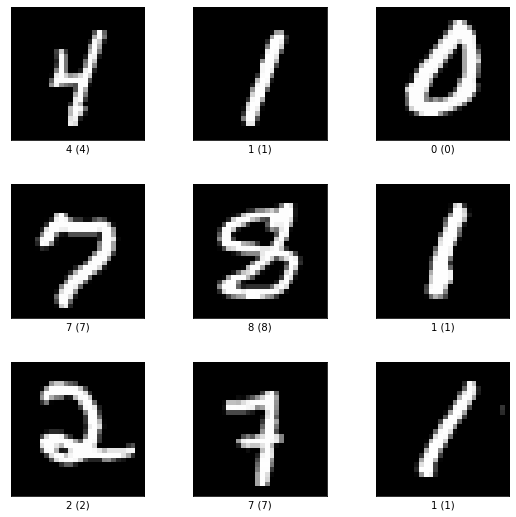

In [4]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

여러 개의 숫자 이미지와 그에 알맞은 레이블이 출력되었을 것입니다. 이어서 아래 코드를 실행해 학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의합니다. 

이미지 픽셀값을 -1~1 사이의 범위로 변경했고, 레이블 정보를 원-핫 인코딩(one-hot encoding)했습니다.

GAN과 cGAN 각각을 실험해 보기 위해 **label 정보 사용 유무**에 따라 `gan_preprocessing()과 cgan_preprocessing()` 두 가지 함수를 구성해 놓았습니다.

In [5]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인해봅시다. 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 합니다.

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


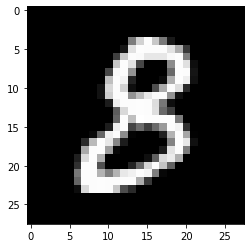

In [6]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

원-핫 인코딩으로 표현된 Label과 출력된 이미지가 일치하는지 확인하고싶지만, 보는 법을 모르시겠다구요? 

0과 1로 이루어진 원-핫 벡터에는 각자 고유의 인덱스가 있습니다. 
MNIST의 경우, 숫자 0은 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.],  
숫자 6은 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]의 값을 가집니다. 이제 위 코드의 output을 확인해 이미지 i와 라벨 j가 일치하는지 확인해 봅니다


## GAN Generator 구성하기

이번 구현은 Tensorflow2의 Subclassing 방법을 이용하겠습니다. Subclassing 방법은 tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고,  

구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행합니다.  

이러한 Subclassing 방법은 Pytorch의 모델 구성 방법과도 매우 유사하므로 이에 익숙해진다면 Pytorch의 모델 구성 방법도 빠르게 습득할 수 있습니다.

먼저 GAN의 Generator를 아래와 같이 구현합니다.

In [7]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


__init__() 메서드 안에서 사용할 모든 레이어를 정의했습니다. 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용하는 것으로 확인됩니다.

call() 메서드에서는 노이즈를 입력받아 __init__()에서 정의된 레이어들을 순서대로 통과합니다.

Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환됩니다.

## cGAN Generator 구성하기

이번에는 cGAN의 Generator를 살펴봅시다.

In [8]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


GAN의 Generator보다 구현이 복잡한듯 하지만 ,이전에 cGAN을 이해한 대로 두 구조의 차이점은 레이블 정보가 추가된다는 것 뿐입니다. 이번에는 여러분이 위 코드를 자세히 보고, 어떠한 연산이 이루어지는지 생각해봅시다.

**cGAN의 입력은 2개(노이즈 및 레이블 정보)라는 점을 기억해주세요. (이전 GAN코드와 비교하여 잘 생각해 봅시다)**


# 20-5. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기

**GAN Discriminator 구성하기

이전에 임의 노이즈 및 레이블 정보로부터 숫자 이미지를 생성하는 Generator를 구현했습니다.  
이번에는 실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해 보겠습니다.

먼저 GAN의 Discriminator를 아래와 같이 구현합니다.

In [9]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


여기에서는 __init__()에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓아놓았습니다.  
이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리합니다.   
Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이며, 이를 fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용됩니다. 

이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시킵니다. 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됩니다.


## cGAN Discriminator 구성하기

다음으로 구현할 cGAN의 Discriminator는 Maxout이라는 특별한 레이어가 사용됩니다.  
Maxout은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 합니다.  
만약 2개의 fully-connected 레이어를 사용할 때 Maxout을 식으로 표현하면 아래와 같습니다.  
<br>
<center>$max(w_1^Tx+b_1,\ w_2^Tx+b_2)$</center>

아래 코드와 같이 Maxout을 구성할 수 있습니다.

tensorflow.keras.layers.Layer 를 상속받아 레이어를 정의

이전에 모델을 정의한 것과 비슷하게 __init__(), call() 메서드를 구성

In [11]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력합니다. 

예를 들어, 사용할 Maxout 레이어가 units=100, pieces=10으로 설정 된다면 입력으로 부터 100차원의 representation을 10개 만들고, 10개 중에서 최대값을 가져와 최종 1개의 100차원 representation이 출력됩니다.  
식으로 나타낸다면 아래와 같습니다. (위 예시에서는 각각의 wx+b가 모두 100차원 입니다)  
<br>
<center>
$max(w_1^Tx+b_1,\ w_2^Tx+b_2, \ …, \ w_9^Tx+b_9,\ w_{10}^Tx+b_{10})$
</center>

위에서 정의한 Maxout 레이어를 3번만 사용하면 아래와 같이 쉽게 cGAN의 Discriminator를 구성

In [12]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용됩니다.  
그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한번씩 통과한 후 서로 결합되어 Maxout 레이어를 한번 더 통과합니다. 
마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됩니다.

# 20-6. 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

이전에 정의한 Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해봅시다.

우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의합니다.

진짜 및 가짜를 구별하기 위해 Binary Cross Entropy를 사용하고, Adam optimizer를 이용해 학습하겠습니다.

In [13]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


## GAN으로 MNIST 학습하기

이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용합니다.
여기서는 입력으로 사용되는 노이즈를 100차원으로 설정했으며, 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 아래와 같이 작성했습니다.

In [14]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


위 함수를 이용해 우선 10 epoch만큼 학습을 진행해 보겠습니다. 100번의 반복마다 각 손실(loss)을 출력하도록 했습니다.

In [15]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.229332447052002, D:0.12701073288917542
[1/10 EPOCHS, 200 ITER] G:2.818270683288574, D:0.1273699849843979
[1/10 EPOCHS, 300 ITER] G:3.1818745136260986, D:0.06645398586988449
[1/10 EPOCHS, 400 ITER] G:2.211949348449707, D:0.1650940626859665
[2/10 EPOCHS, 100 ITER] G:3.7381231784820557, D:0.13439610600471497
[2/10 EPOCHS, 200 ITER] G:2.8182947635650635, D:0.2515435814857483
[2/10 EPOCHS, 300 ITER] G:4.576297760009766, D:0.178561732172966
[2/10 EPOCHS, 400 ITER] G:4.207810401916504, D:0.07998346537351608
[3/10 EPOCHS, 100 ITER] G:3.8972601890563965, D:0.1771889626979828
[3/10 EPOCHS, 200 ITER] G:3.787623882293701, D:0.06863457709550858
[3/10 EPOCHS, 300 ITER] G:3.0488617420196533, D:0.1123187318444252
[3/10 EPOCHS, 400 ITER] G:3.9158935546875, D:0.07256829738616943
[4/10 EPOCHS, 100 ITER] G:3.096614360809326, D:0.18518757820129395
[4/10 EPOCHS, 200 ITER] G:4.650439739227295, D:0.052910856902599335
[4/10 EPOCHS, 300 ITER] G:4.456396579742432, D:0.0406892523169517

짧은 시간 학습된 모델을 테스트해 봅시다. 100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화합니다.
경고메시지가 출력된다면 그냥 무시하셔도 됩니다.

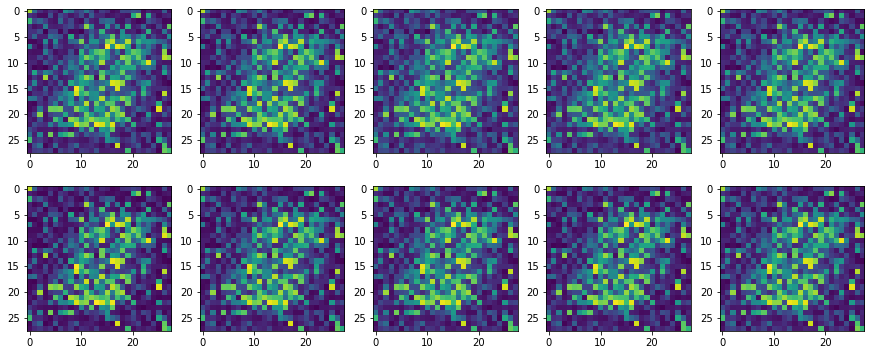

In [16]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

결과를 보니 아마도 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없나 봅니다.

위 구현을 그대로 500 epoch 학습한 가중치를 아래에 첨부했으니 한번 사용해 봅시다.

첨부된 파일(GAN_500.zip)을 다운로드하여 아래와 같이 작업환경을 구성해 주세요.

GAN_500.zip   
$ mkdir -p ~/aiffel/conditional_generation/gan  
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip
$ mv GAN_500.zip ~/aiffel/conditional_generation/gan  
$ cd ~/aiffel/conditional_generation/gan && unzip GAN_500.zip  

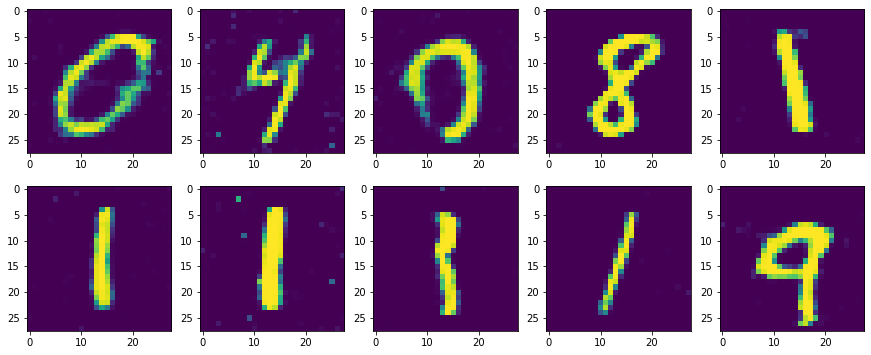

In [17]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

위에 보이는 10개의 결과 이미지는 서로 다른 숫자들이 시각화되었을 것입니다 (아닐 수도 있습니다).

이러한 방법으로는 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 할 수 있습니다. 내가 원하는 숫자를 바로 얻어내기 위해 아래에서 cGAN을 학습 시켜 봅시다.

## cGAN으로 MNIST 학습하기

이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용합니다.
위에서 실행했던 GAN 학습처럼 약간의 학습으로는 제대로 된 생성 결과를 얻을 수 없을 테니 이번에는 연습 삼아 1 epoch만 학습 시켜 보겠습니다.

In [18]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:3.600715160369873, D:0.03285348415374756
[1/1 EPOCHS, 199 ITER] G:3.141249895095825, D:0.07950806617736816
[1/1 EPOCHS, 299 ITER] G:4.559067726135254, D:0.03754923492670059
[1/1 EPOCHS, 399 ITER] G:3.5702288150787354, D:0.06179344654083252


학습 과정에서 Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없습니다.

위 코드로 짧게나마 학습시켜봤는데, 충분한 학습이 되기엔 더 많은 시간을 투자해야 합니다.

첨부된 파일(CGAN_500.zip)을 다운로드하여 아래와 같이 작업환경을 구성

CGAN_500.zip   
$ mkdir -p ~/aiffel/conditional_generation/cgan  
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip  
$ mv CGAN_500.zip ~/aiffel/conditional_generation/cgan  
$ cd ~/aiffel/conditional_generation/cgan && unzip CGAN_500.zip  

아래 코드의 가장 윗줄에 있는 number라는 변수에 숫자를 할당하지 않았습니다. 

number에 0~9 사이의 숫자 중 생성하길 원하는 숫자를 입력해 주시고 아래 코드를 실행.


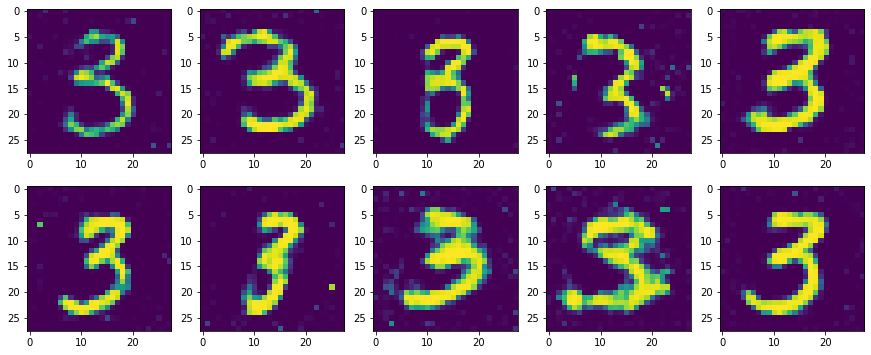

In [19]:
number = 3  # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

출력된 10개 시각화 결과는 어떤가요? 아마도 number에 입력한 숫자에 해당하는 손글씨가 시각화되었을 것입니다.

cGAN을 사용해 조건을 주고 학습하면 이렇게 특정한 숫자를 만들어내기가 훨씬 쉬워졌습니다.😆

# 20-7. GAN의 입력에 이미지를 넣는다면? Pix2Pix

지금까지 cGAN에 대해 알아보고 실험해보면서, 작은 조건만으로 우리가 원하는 클래스의 이미지를 생성할 수 있음을 확인했습니다. 만약 입력자체가 조건이 된다면 어떨까요? 

cGAN과 같이 클래스 레이블 등의 조건을 함께 입력하는 것이 아니라, 조금 더 자세하게 내가 원하는 이미지를 얻기 위해 이미지를 조건으로 줄 수 없을까요? 

이번에 소개드릴 Pix2Pix는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델입니다.

`Pix2Pix`를 제안한 논문의 제목은 Image-to-Image Translation with Conditional Adversarial Networks 로 하고자 하는 바가 제목에 그대로 담겨 있습니다.

`Conditional Adversarial Networks`로 `Image-to-Image Translation을 수행한다`는 뜻이죠.. Conditional Adversarial Networks는 이전까지 알아봤던 cGAN과 같은 구조를 말하는 것인데, Image-to-Image Translation이란 단어는 무엇을 뜻하는 걸까요? 아래 Pix2Pix 논문에서 수행한 결과를 먼저 살펴봅시다.

이후 표기되는 이미지에 대한 출처가 명시되지 않은 경우, Pix2Pix 논문에서 가져왔음을 미리 알려드립니다.

`Image-to-Image Translation`은 말 그대로 `이미지 간 변환`을 말합니다.😅

위 결과의 첫 번째 [Labels to Street Scene] 이미지는 픽셀별로 레이블 정보만 존재하는 segmentation map을 입력으로 실제 거리 사진을 생성해 내었고, 이 외에 흑백 사진을 컬러로 변환하거나, 낮에 찍은 사진을 밤에 찍은 사진으로 변환하거나, 가방 스케치를 이용해 채색된 가방을 만들기도 합니다.

한 이미지의 픽셀에서 다른 이미지의 픽셀로(pixel to pixel) 변환한다는 뜻에서 Pix2Pix라는 이름으로 불립니다. 이 구조는 최근 활발하게 연구 및 응용되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 되는 연구입니다.

노이즈와 레이블 정보를 함께 입력했던 cGAN은 fully-connected 레이어를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 `Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용`합니다. 

GAN 구조를 기반으로 하기 때문에 크게 Generator와 Discriminator 두 가지 구성 요소로 이루어집니다. 아래에서 자세히 알아보겠습니다.

## Pix2Pix (Generator)

Generator는 어떠한 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용됩니다. 여기서 `입력 이미지와 변환된 이미지의 크기는 동일`해야 하며, 이러한 문제에서 흔히 사용되는 구조는 아래 그림과 같은 `Encoder-Decoder 구조`입니다.

Encoder에서 입력 이미지(x)를 받으면 단계적으로 `이미지를 down-sampling`하면서 입력 이미지의 중요한 `representation을 학습`합니다. Decoder에서는 이를 이용해 반대로 `다시 이미지를 up-sampling`하여 입력 이미지와 `동일한 크기의 변환된 이미지(y)를 생성`해냅니다. 

이러한 과정은 모두 `convolution 레이어로 진행`되며, 레이어 내의 수많은 파라미터를 학습하여 잘 변환된 이미지를 얻도록 합니다. 여기서 한 가지 짚고 넘어갈 부분은, Encoder의 최종 출력은 위 그림 중간에 위치한 가장 작은 사각형이며, `bottleneck` 이라고도 불리는 이 부분은 입력 이미지(x)의 가장 중요한 특징만을 담고 있습니다.

과연 이 중요하지만 작은 특징이 변환된 이미지(y)를 생성하는데 충분한 정보를 제공할까요? 이와 같은 점을 보완하기 위해 논문에서는 Generator 구조를 하나 더 제안합니다.  

아래 그림과 같은 **U-Net **구조입니다.

위에서 살펴본 단순한 Encoder-Decoder로 구성된 Generator와 다른 점은, 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있다는 것입니다. Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용하는 방법이며, 이러한 U-Net 구조의 Generator를 사용해 아래와 같이 단순한 Encoder-Decoder 구조의 Generator를 사용한 결과에 비해 비교적 선명한 결과를 얻을 수 있었습니다.

여기서 U-Net은 이전에 segmentation 작업을 위해 제안된 구조입니다. U-Net에 대한 자세한 사항은 이번 노드의 학습 범위를 벗어나므로 아래에 잘 정리된 자료를 첨부합니다.
    • U-Net 논문 리뷰
    
## Pix2Pix (Loss Function)

예상컨데 위 Generator 구조를 보면서 한 번쯤 생각해 보셨을 것 같은 사항으로는 "Generator만으로도 이미지 변환이 가능하지 않을까?" 입니다. 

이미지 변환이 가능은 하지만 문제는 변환된 이미지의 품질입니다. 아래 사진의 L1이라 써있는 결과가 Generator 만을 사용해 변환된 이미지와 실제 이미지 사이의 L1 손실을 이용해 만들어낸 결과입니다.

L1 이라 쓰여있는 Generator만으로 생성된 결과는 매우 흐릿합니다. 이미지를 변환하는데 `L1(MAE)이나 L2(MSE) 손실`만을 이용해서 학습하는 경우 이렇게 `결과가 흐릿해지는 경향`이 있습니다. 

Generator가 단순히 이미지의 평균적인 손실만을 줄이고자 파라미터를 학습하기 때문에 이러한 현상이 불가피합니다.

반면 위 그림의 `cGAN이라 쓰여진 GAN 기반의 학습 방법`은 비교적 훨씬 `더 세밀한 정보를 잘 표현`하고 있습니다. Discriminator를 잘 속이려면 Generator가 (Ground truth라고 쓰여진 이미지같이) 진짜 같은 이미지를 만들어야 하기 때문이죠. 

논문에서는 `L1손실`과 `GAN 손실`을 같이 사용하면 더욱더 좋은 결과를 얻을 수 있다고 합니다 (위 그림의 L1+cGAN).

## Pix2Pix (Discriminator)

위 결과에서 보듯 실제 같은 이미지를 얻기 위해서는 GAN의 학습 방법을 이용해야 하며, 위에서 설명한 Generator를 발전시킬 서포터이자 경쟁자, Discriminator가 필요하겠죠. 혹시 이전에 다뤘던 DCGAN의 Discriminator 기억하시나요? 아래 그림은 DCGAN의 Discriminator를 나타냅니다.

DCGAN의 Discriminator는 생성된 가짜이미지 혹은 진짜이미지를 하나씩 입력받아 convolution 레이어를 이용해 점점 크기를 줄여나가면서, 최종적으로 하나의 이미지에 대해 하나의 확률값을 출력했습니다. Pix2Pix는 이 과정에서 의문을 갖습니다.

하나의 전체 이미지에 대해 하나의 확률값만을 도출하는 것이 진짜 혹은 가짜를 판별하는 데 좋은 것일까?

Pix2Pix는 이러한 의문점을 가지고 아래 그림과 같은 조금 다른 방식의 Discriminator를 사용합니다.

위 그림은 Pix2Pix에서 사용되는 `Discriminator`를 간략하게 나타냅니다. 하나의 이미지가 Discriminator의 입력으로 들어오면, `convolution 레이어`를 거쳐 `확률값을 나타내는 최종 결과를 생성`하는데, 그 결과는 하나의 값이 아닌 `여러 개의 값`을 갖습니다 (위 그림의 Prediction은 16개의 값을 가지고 있습니다). 위 그림에서 입력이미지의 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 `진짜/가짜를 판별하는 하나의 확률값을 도출`한다는 것입니다.

이런 방식으로 서로 다른 영역에 대해 진짜/가짜를 나타내는 여러 개의 확률값을 계산할 수 있으며 이 `값을 평균하여 최종 Discriminator의 출력을 생성`합니다. 이러한 방법은 이미지의 일부 영역(patch)을 이용한다고 하여 `PatchGAN`이라고 불립니다. 

일반적으로 이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법입니다.

아래 그림은 (위 그림의 파란색 점선 같은) 판별 영역을 다양한 크기로 실험하여 그 결과를 보여줍니다.

마지막에 보이는 286x286이라 적힌 이미지는 DCGAN의 Discriminator와 같이 전체 이미지에 대해 하나의 확률값을 출력하여 진짜/가짜를 판별하도록 학습한 결과입니다 (입력 이미지 크기가 286x286 입니다). 

70x70 이미지는 Discriminator입력 이미지에서 70x70 크기를 갖는 일부 영역에 대해서 하나의 확률값을 출력한 것이며, 16x16, 1x1로 갈수록 더 작은 영역을 보고 각각의 확률값을 계산하므로 Discriminator의 출력값의 개수가 더 많습니다. 

위 4개의 이미지를 살펴보면, 너무 작은 patch를 사용한 결과(1x1, 16x16)는 품질이 좋지 않으며, 70x70 patch를 이용한 결과가 전체 이미지를 사용한 결과(286x286)보다 조금 더 사실적인 이미지를 생성하므로 PatchGAN의 사용이 성공적이라고 볼 수 있을 것 같습니다.

# 20-8. 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기

이번에는 앞서 알아본 pix2pix 모델에 대해서 직접 구현하고 실험해봅시다. 사용해볼 데이터셋은 Sketch2Pokemon이라는 데이터셋입니다.

    • Sketch2Pokemon info
    
위 출처에는 학습용 데이터 셋에 830개의 이미지가 있으며, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성되어 있다고 합니다. 아래 링크에서 다운로드해서 직접 확인해봅시다. (위 출처에서 학습용 데이터셋만 따로 가져왔습니다)

sketch2pokemon.zip  
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip  
$ mv sketch2pokemon.zip ~/aiffel/conditional_generation  
$ cd ~/aiffel/conditional_generation && unzip sketch2pokemon.zip  

In [22]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


number of train examples : 830
출처의 내용과 같이 830개 이미지가 있음을 확인할 수 있습니다.
이번에는 아래 코드를 이용해 각각의 이미지들이 어떻게 생겼는지 확인해 봅시다. 학습용 데이터셋에서 임의로 6장을 선택하여 시각화합니다.

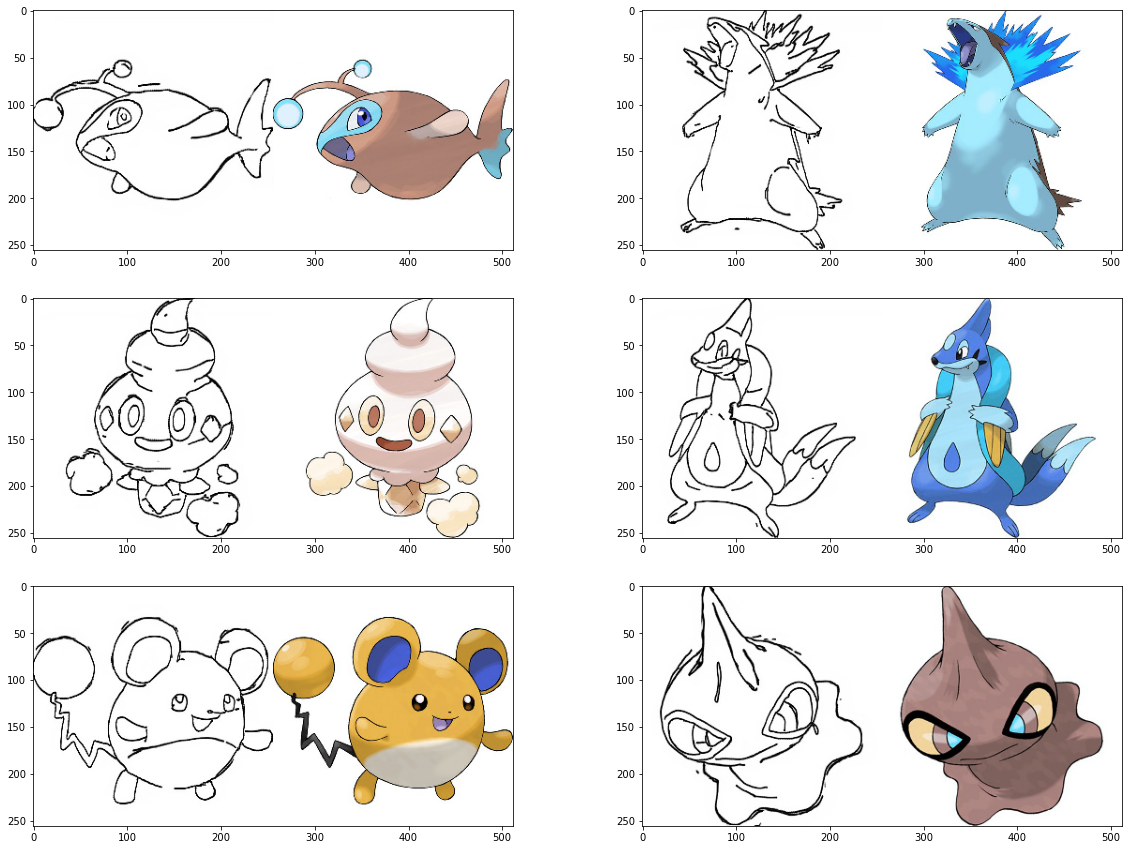

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

하나의 이미지에 포켓몬 스케치와 실제 포켓몬 이미지가 함께 포함되어 있음을 확인할 수 있습니다. 위 코드를 여러 번 반복 실행해 보면 일부는 제대로 스케치 되지 않은 이미지도 확인할 수 있습니다. 출처를 확인해보니 직접 그려서 만든 데이터셋이 아닌 스케치 생성 모델을 이용해서 만들었다고 하네요 😅
이미지를 하나 열어 아래와 같이 크기를 확인해 보겠습니다.

In [24]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 512, 3)으로 확인되었습니다. 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 될 것 같네요.
아래 코드로 이미지를 나누어 봅시다.

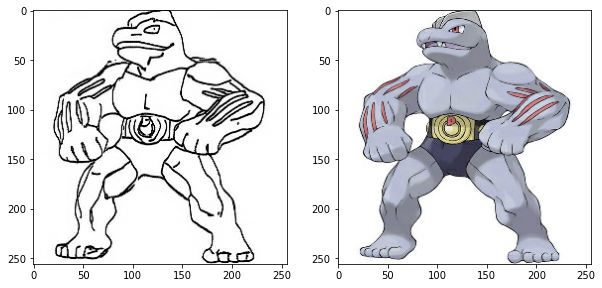

In [25]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

위와 같이 두 개 이미지로 나누었습니다. 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표입니다.
앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 약 800개뿐입니다. 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보겠습니다.

In [26]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용합니다.

두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다. 

1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)  
2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다.   (tf.image.random_crop)   
3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)  
4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)   
5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)  
위와 같이 구성한 함수를 데이터에 적용해 시각화 해봅시다.  

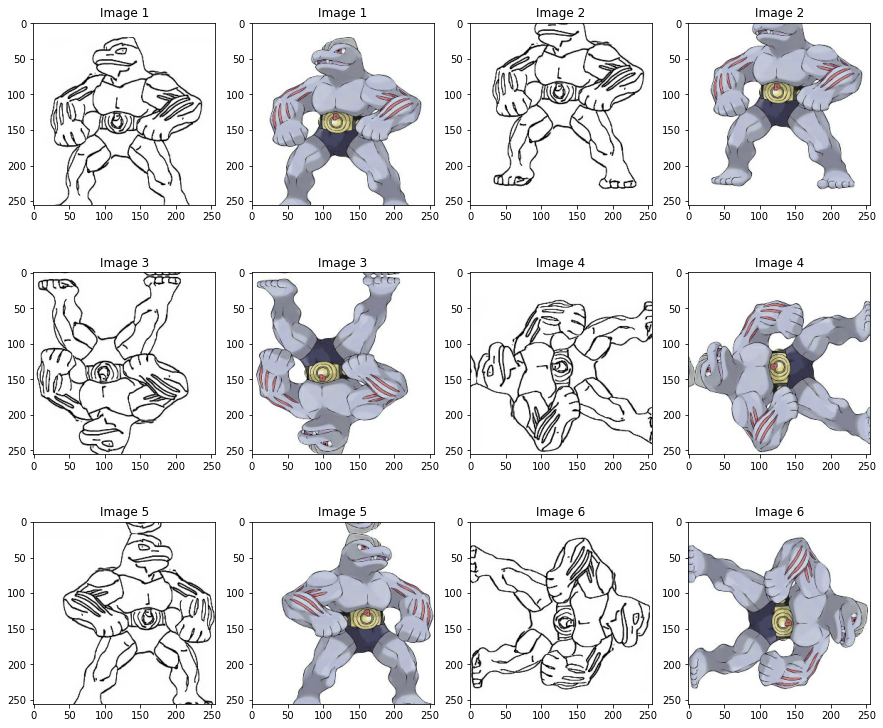

In [27]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

매우 다양한 이미지가 생성됩니다. 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있습니다.😆
마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보겠습니다.

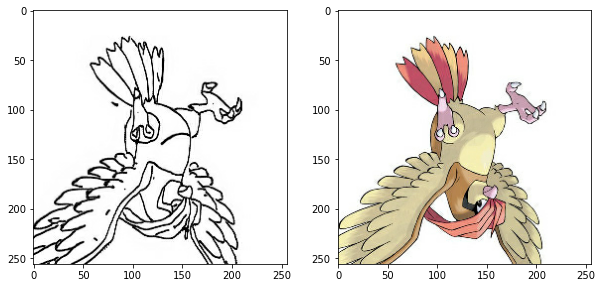

In [28]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 20-9. 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기

이제부터 본격적으로 Pix2Pix 구조를 구현합니다. 앞서 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들겠습니다.  

## Generator의 구성요소 알아보기

512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution → BatchNorm → 50% Dropout → ReLU

아마도 위 두 개의 질문에 잘 답하셨다면, Generator를 구성하는데 필요한 레이어들은 대략적으로 숙지하셨으리라 생각됩니다.

이번에는 아래와 같이 보기 쉽게 표현한 그림을 통해 Generator의 전체 구조를 머리속에 조금 더 자세히 그려봅시다.

https://neurohive.io/en/popular-networks/pix2pix-image-to-image-translation/
위 그림에서 ENCODE 또는 DECODE라고 쓰인 각각의 블록을 기준으로 양쪽에 쓰인 입출력 크기에 집중해주세요.

"in"이라고 쓰여진 입력 부분부터 윗줄의 화살표를 쭉 따라가면 계산된 결과의 (width, height) 크기가 점점 절반씩 줄어들며 최종적으로 (1,1)이 되고, 채널의 수는 512까지 늘어나는 것을 확인할 수 있습니다.

처음 입력부터 시작해서 (1,1,512) 크기를 출력하는 곳까지가 Encoder 부분입니다.
이어서 아랫줄 화살표를 따라가면 (width, height) 크기가 점점 두 배로 늘어나 다시 (256, 256) 크기가 되고, 채널의 수는 점점 줄어들어 처음 입력과 같이 3채널이 됩니다. (1,1,512)를 입력으로 최종 출력까지의 연산들이 Decoder 부분입니다.

## Generator 구현하기

위 정보들을 토대로 여러분의 머릿속에 희미하게 그려진 Generator의 Encoder 부분을 구현하겠습니다.

먼저 위 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었습니다.

In [31]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


__init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있습니다.  
이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했습니다.  
Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있습니다.

In [29]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정해 두었으며, blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과합니다. 앞서 퀴즈로 알아본 것처럼 Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않습니다.  

get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았습니다. 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴봅시다. 만들어 놓은 get_summary 메서드를 바로 불러오시면 됩니다.

In [32]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있습니다.  

이번엔 Decoder를 구현합니다. Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러 번 반복하여 아래와 같이 Decoder를 만들겠습니다.

In [33]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있습니다.
마찬가지로 (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해봅시다.

In [34]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

(width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었습니다.

위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있겠군요.  
스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있습니다.

아래 코드와 같이 tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성해봅시다.

In [35]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_2 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


Generator를 잘 작동시키기 위해서는 약 4000만 개의 파라미터를 잘 학습

# 20-10. 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기

지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 봤습니다.
하지만 앞서 설명드린 것처럼 Pix2Pix의 Generator 구조는 아래 그림처럼 두 가지를 제안했습니다.

아래 그림으로 다시 한번 봅시다.

위 그림에서 각 구조 아래에 표시된 이미지는 해당 구조를 Generator로 사용했을 때의 결과입니다.

단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보입니다.
이전 단계에서 구현했던 Generator는 위 그림의 Encoder-decoder 구조입니다.

Encoder에서 출력된 결과를 Decoder의 입력으로 연결했고, 이 외에 추가적으로 Encoder와 Decoder를 연결시키는 부분은 없었습니다. 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 위 그림의 U-Net 구조를 만들고 실험해봅시다.

(아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용하겠습니다)

먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했었습니다.

In [36]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


여기서 특별히 수정해야 할 부분은 없습니다. 그대로 가져다가 사용하겠습니다.  

정의된 블록들을 이용해 한 번에 U-Net Generator를 정의해 보겠습니다. 아래 모델의 __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 forward propagation 하도록 합니다.  
이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해봅시다.

In [38]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


먼저, __init__() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행합니다.

이때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았습니다.

이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,

features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됩니다.

마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인해봅시다.

In [39]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

이전 Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만 개 였는데, Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개로 꽤나 많이 늘어났습니다.

U-Net Generator의 경우, Encoder 내 블록 출력이 함께 연결되어 Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x(512+512) 입니다.

정리하면, U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어났습니다.

# 20-11. 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기

Generator만으로 좋은 결과를 도출하기에는 부족합니다. 조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요합니다.

이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜 봅시다.

## Discriminator의 구성요소 알아보기

Generator를 만들기 전에 봤듯이 먼저 Pix2Pix 논문에서 Discriminator를 구성하는데 필요한 정보를 아래에 가져왔습니다.

Generator의 구성 요소와 똑같이 "C64" 등으로 표기되어있습니다. 진짜 및 가짜 이미지를 판별하기 위해 최종 출력에 sigmoid를 사용하는 것을 제외하면 특별한 변경 사항은 없는 것 같습니다.

이어서 아래의 보기 쉽게 표현한 그림을 통해 Discriminator의 구조를 머리속에 조금 더 자세히 그려봅시다.

https://neurohive.io/en/popular-networks/pix2pix-image-to-image-translation/  

Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, ENCODE 라고 쓰인 5개의 블록을 통과합니다. 이 중 마지막 블록을 제외한 4개 블록은 위 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가되었습니다.

최종적으로 출력되는 크기는 (30,30,1) 이며, 위 그림의 출력 이전의 2개의 ENCODE 블록을 보면 각각의 출력 크기가 32, 31, 30으로 1씩 감소하는 것을 알 수 있습니다. 

Generator에서도 사용했던 2 stride convolution에 패딩을 이용하면 (width, height) 크기가 절반씩 감소할 것입니다. 1 stride convolution에 패딩을 하지 않는다면 (width, height) 크기는 (필터 크기가 4이므로) 3씩 감소할 텐데, 그림과 같이 1씩 감소하도록 하려면 무언가 다른 방법을 써야 할 것 같네요.🤔 이 부분이 지금 이해되지 않는다면 아래 코드에서 다시 다룰 테니 우선 넘어갑시다.

추가적으로 위 그림에서 최종 출력 크기가 (30,30)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문입니다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정입니다. 이 부분에 대한 설명은 아래 참고 자료로 대신하겠습니다. (아랫글 마지막 부분에 언급합니다)


    • Understanding PatchGAN
이 부분만 제외하면 전반적으로는 Generator보다 간단한 것 같습니다. 구현해봅시다.

## Discriminator 구현하기

마찬가지로 Discriminator에 사용할 기본적인 블록

In [42]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


__init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했습니다. 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능합니다.

In [43]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


이러한 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있습니다. 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 되겠습니다.

Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했습니다.
사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어봅시다.

In [44]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


__init__() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었습니다. 

첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용했습니다.
각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인해봅시다.

In [48]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block_5 (DiscBlock)        (None, 128, 128, 64) 6144        concatenate_8[0][0]        

두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치합니다.

시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해보겠습니다.

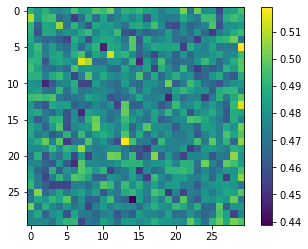

In [49]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

이전 PatchGAN에 대해 설명했던 것처럼, 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70,70) 패치에 대한 분류 결과입니다. 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있겠죠. 각각의 픽셀값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는 데 사용합니다.

드디어 Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝났습니다.
다음 단계에서 본격적인 모델 학습을 진행해 봅시다!

# 20-12. 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기

이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해 봅시다. 먼저 학습에 필요한 손실함수부터 정의하겠습니다.
논문의 여러 실험 결과 중 손실함수 선택에 따른 결과의 차이는 아래와 같습니다.

레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 냈습니다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해 봅시다.

In [50]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


Generator 및 Discriminator의 손실 계산을 각각 정의했습니다.

    • Generator의 손실함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있습니다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.
    
    • Discriminator의 손실함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.
    
사용할 optimizer는 논문과 동일하게 아래와 같이 설정합니다.

In [51]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했습니다.

In [52]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않습니다.  
다만 위 코드의 gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인하셨나요? (## 이 표시가 있는 부분을 확인해 주세요.) 논문에서는 Generator의 손실을 아래와 같이 정의했습니다.  

<br>
<center>
$G^* = \arg \min_G \max_D \mathcal{L}{cGAN}(G,D) + \lambda \mathcal{L}{L1}(G)$
</center>
위 식에서 λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ=100을 사용했습니다.

앞서 정의한 함수를 이용해서 학습을 진행합니다. 우선 10 epoch 학습해 봅시다.

In [54]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9665                     
L1_loss:0.5095                     
Discriminator_loss:1.1062

EPOCH[1] - STEP[20]                     
Generator_loss:1.2226                     
L1_loss:0.3123                     
Discriminator_loss:1.3876

EPOCH[1] - STEP[30]                     
Generator_loss:0.8361                     
L1_loss:0.2875                     
Discriminator_loss:1.2431

EPOCH[1] - STEP[40]                     
Generator_loss:0.9619                     
L1_loss:0.2553                     
Discriminator_loss:1.1726

EPOCH[1] - STEP[50]                     
Generator_loss:1.7616                     
L1_loss:0.2624                     
Discriminator_loss:0.7053

EPOCH[1] - STEP[60]                     
Generator_loss:2.0776                     
L1_loss:0.2738                     
Discriminator_loss:0.4230

EPOCH[1] - STEP[70]                     
Generator_loss:2.6566                     
L1_loss:0.2152                    

EPOCH[3] - STEP[170]                     
Generator_loss:0.7607                     
L1_loss:0.1999                     
Discriminator_loss:0.7695

EPOCH[3] - STEP[180]                     
Generator_loss:0.3923                     
L1_loss:0.2254                     
Discriminator_loss:1.3507

EPOCH[3] - STEP[190]                     
Generator_loss:1.7792                     
L1_loss:0.2673                     
Discriminator_loss:0.2338

EPOCH[3] - STEP[200]                     
Generator_loss:1.8191                     
L1_loss:0.2229                     
Discriminator_loss:1.5726

EPOCH[4] - STEP[10]                     
Generator_loss:0.7218                     
L1_loss:0.2406                     
Discriminator_loss:1.0873

EPOCH[4] - STEP[20]                     
Generator_loss:1.0048                     
L1_loss:0.2551                     
Discriminator_loss:0.6533

EPOCH[4] - STEP[30]                     
Generator_loss:1.8915                     
L1_loss:0.2398                

EPOCH[6] - STEP[130]                     
Generator_loss:2.2849                     
L1_loss:0.2532                     
Discriminator_loss:0.3992

EPOCH[6] - STEP[140]                     
Generator_loss:1.7089                     
L1_loss:0.2212                     
Discriminator_loss:0.4724

EPOCH[6] - STEP[150]                     
Generator_loss:0.9814                     
L1_loss:0.2380                     
Discriminator_loss:0.6604

EPOCH[6] - STEP[160]                     
Generator_loss:1.7910                     
L1_loss:0.2216                     
Discriminator_loss:0.8252

EPOCH[6] - STEP[170]                     
Generator_loss:2.8718                     
L1_loss:0.2800                     
Discriminator_loss:0.4611

EPOCH[6] - STEP[180]                     
Generator_loss:2.5692                     
L1_loss:0.2269                     
Discriminator_loss:0.2797

EPOCH[6] - STEP[190]                     
Generator_loss:3.8506                     
L1_loss:0.2310             

EPOCH[9] - STEP[90]                     
Generator_loss:1.6941                     
L1_loss:0.2655                     
Discriminator_loss:0.3196

EPOCH[9] - STEP[100]                     
Generator_loss:0.5480                     
L1_loss:0.2429                     
Discriminator_loss:1.2027

EPOCH[9] - STEP[110]                     
Generator_loss:2.4522                     
L1_loss:0.2243                     
Discriminator_loss:1.2051

EPOCH[9] - STEP[120]                     
Generator_loss:1.3341                     
L1_loss:0.2386                     
Discriminator_loss:1.6498

EPOCH[9] - STEP[130]                     
Generator_loss:1.2543                     
L1_loss:0.2227                     
Discriminator_loss:0.6353

EPOCH[9] - STEP[140]                     
Generator_loss:2.8208                     
L1_loss:0.2655                     
Discriminator_loss:0.7548

EPOCH[9] - STEP[150]                     
Generator_loss:3.0875                     
L1_loss:0.2353              

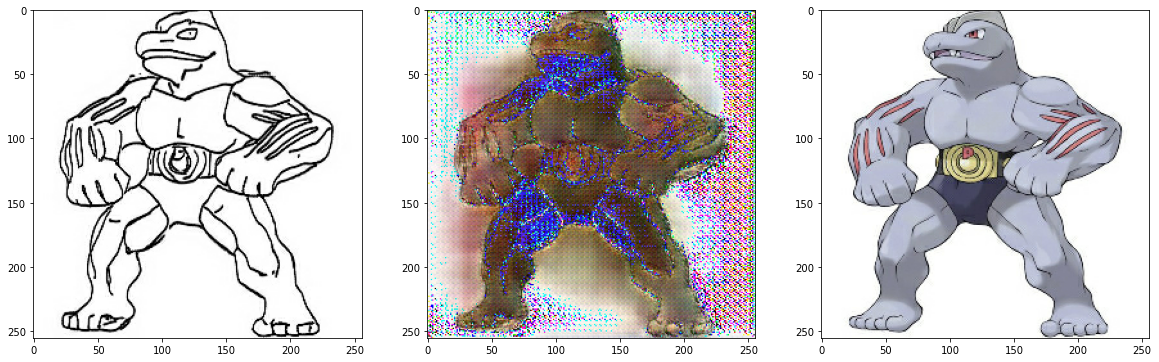

In [55]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

데이터셋을 제공한 출처를 보면, Pix2Pix로 128 epoch 학습 후 테스트 결과가 아래와 같다고 합니다.
이전 10 epoch 학습의 결과보다는 훨씬 낫지만, 조금 오래 학습했어도 채색해야 할 전체적인 색감 정도만 학습되며 아직까지 세부적으로는 제대로 채색되지 않다는 것을 확인할 수 있습니다.

지금까지 꽤 많은 시간을 투자해서 `Encoder-Decoder Generator, U-Net Generator, Discriminator의 구현`까지 이해하느라 고생하셨습니다. 앞서 다뤘던 코드의 이해에 큰 어려움이 없었다면, 연습을 통해 이와 비슷한 구조의 모델들 또한 쉽게 구현할 수 있을 것입니다. (U-Net Generator를 구현했으니 원래 segmentation에 사용되었던 U-Net도 쉽게 구현할 수 있습니다!).


이번 학습을 통해서 여러분이 Pix2Pix 구조뿐만 아니라 CNN 기반의 어떠한 구조라도 자신을 갖고 구현

# 20-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기

이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드할 수 있습니다.  
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

cityscapes.zip 

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.

아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해봅시다.

(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)

    • Tensorflow Pix2Pix Tutorial
    
    
## 프로젝트 수행

프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

    1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.    
(어떠한 방법을 사용했는지 적어주세요.)

    2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.  
    
    3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.  
    
    4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.  
    
    5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.  
    
    

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, Model

In [35]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


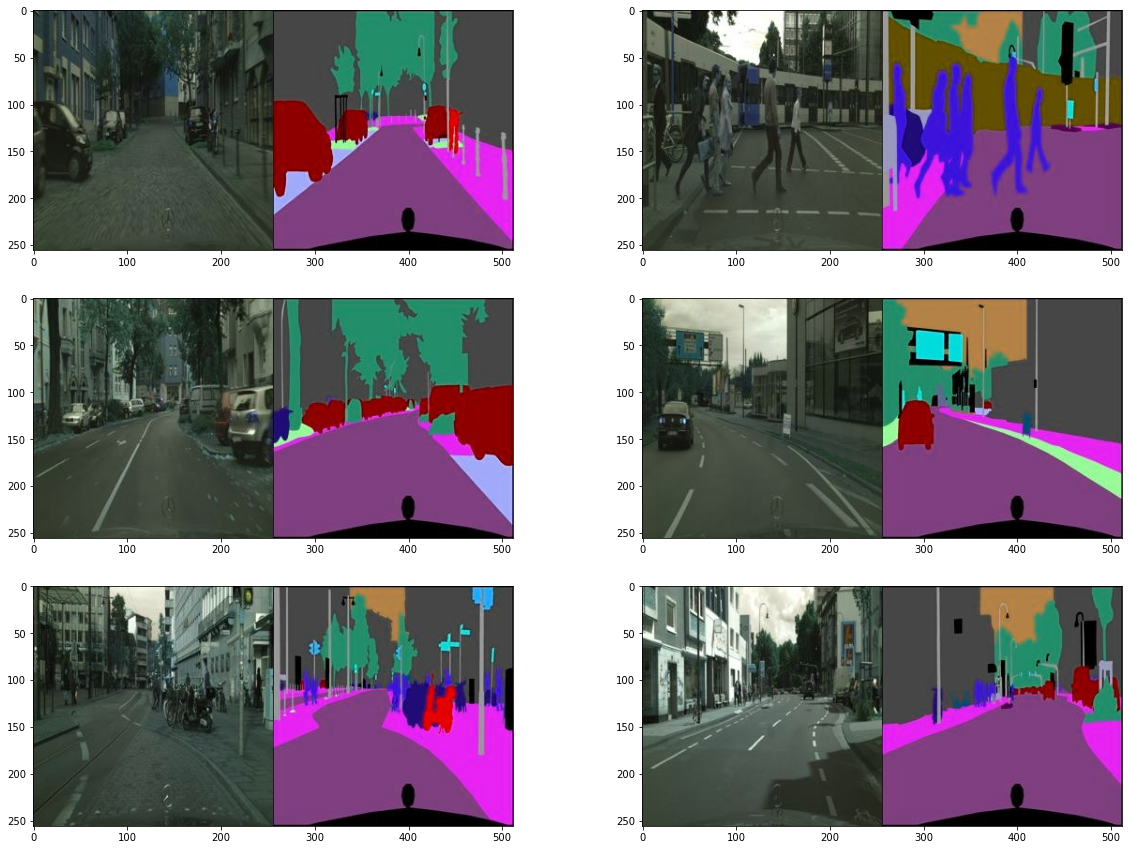

In [36]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(700)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [37]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


붙어있는 두개의 이미지 사진을 나눈다.
- ```normalize``` 함수
- ```denormalize```함수
    - 이후에 시각화(matplotlib)를 통해서 보여주기 위해서는 정규화 되어있는 사진을 다시 원래대로 변환해서 시각화한다.
- ```load_img```함수
    - 이미지를 읽고 decode를 해서 array에 담는다
    - w에는 512인 너비를 반을 나눠서 256의 값이 되고
    - 좌측 반은 sketch로 저장, 우측은 colored로 저장..
    - 그리고 두 개로 나눈 이미지는 normalize를 적용시키면서 반환시킨다

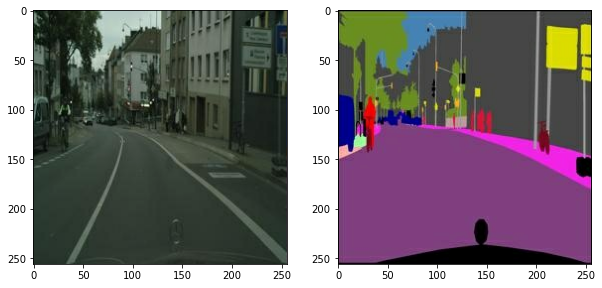

In [38]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

아래에서 사용한 방법은 다음과 같다.
1. 두 이미지가 채널 축으로 연결
2. 1의 결과에 50% 확률로 Reflection padding, constant padding이 30픽셀의 pad width만큼 적용
3. 2의 결과에서 (256, 256, 6) 크기를 가진 이미지를 임의로 잘라낸다
4. 3의 결과물을 50%의 확률로 가로 반전
- 세로반전과 회전은 수행하지 않는다.
    - 일반적으로 도로사진은 그런 사진이 없기 때문에
- 의문점
    - 이미지를 concat시키지 않고 짤릴 경우 기존에 이미지는 하얀색 배경이라서 하얀색이 있는게 문제가 되지 않지만, 도로 이미지의 경우 기존에 segmap에는 색칠이 다 되어 있기 때문에 흰색이 오히려 학습에 도움이 되지 않을 것 같다.
    ![image](https://user-images.githubusercontent.com/48716219/98461359-d5edda00-21ee-11eb-8c6c-6cd0876cd2e1.png)


In [39]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    #out = image.random_flip_up_down(out)
    
#     if tf.random.uniform(()) < .5:
#         degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
#         out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


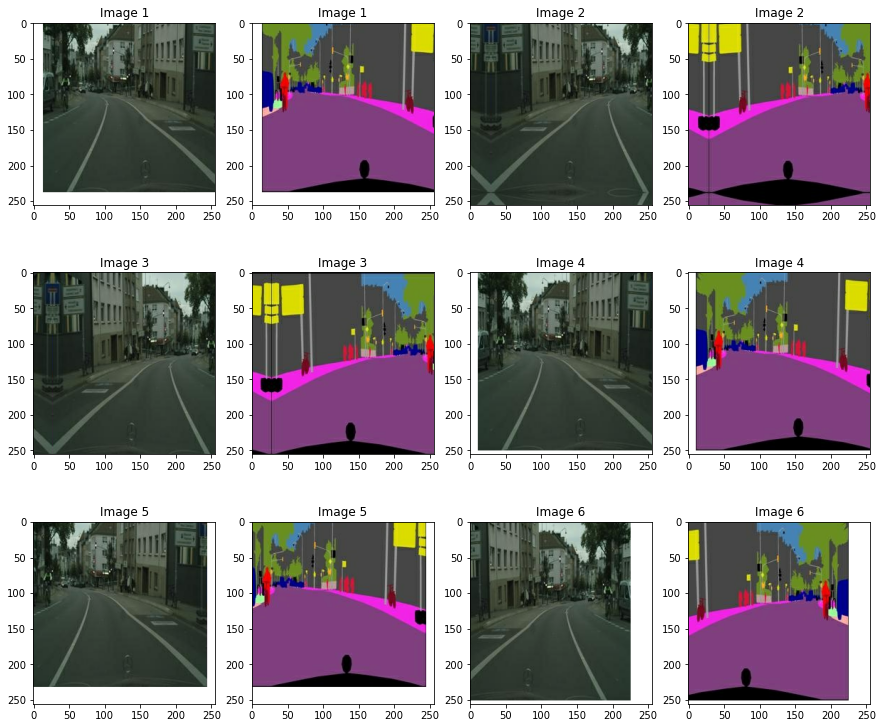

In [40]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

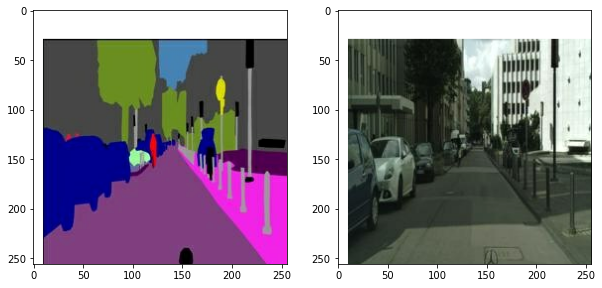

In [41]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# Generator 정의
U-Net Generator를 사용한다

Encoder와 Decoder간의 skip connection이 존재

## EncodeBlock과 DecodeBlock 정의

In [42]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [43]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [44]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_32 (EncodeBlock)   (None, 128, 128, 64) 3072        input_5[0][0]                    
__________________________________________________________________________________________________
encode_block_33 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_32[0][0]            
__________________________________________________________________________________________________
encode_block_34 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_33[0][0]            
____________________________________________________________________________________________

## Diecriminator 구성하기¶

In [45]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [46]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_88 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [47]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [48]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_95 (Concatenate)    (None, 256, 256, 6)  0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
disc_block_20 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_95[0][0]       

In [49]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [50]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [51]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [52]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8630                     
L1_loss:0.3166                     
Discriminator_loss:1.4398

EPOCH[1] - STEP[20]                     
Generator_loss:0.9415                     
L1_loss:0.2494                     
Discriminator_loss:1.3607

EPOCH[1] - STEP[30]                     
Generator_loss:0.8521                     
L1_loss:0.2071                     
Discriminator_loss:1.3228

EPOCH[1] - STEP[40]                     
Generator_loss:0.8563                     
L1_loss:0.1931                     
Discriminator_loss:1.3957

EPOCH[1] - STEP[50]                     
Generator_loss:0.9532                     
L1_loss:0.1720                     
Discriminator_loss:1.4429

EPOCH[1] - STEP[60]                     
Generator_loss:0.9239                     
L1_loss:0.1867                     
Discriminator_loss:1.1221

EPOCH[1] - STEP[70]                     
Generator_loss:1.0026                     
L1_loss:0.1897                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.7720                     
L1_loss:0.1992                     
Discriminator_loss:0.3752

EPOCH[3] - STEP[80]                     
Generator_loss:1.8807                     
L1_loss:0.1503                     
Discriminator_loss:0.7347

EPOCH[3] - STEP[90]                     
Generator_loss:2.8760                     
L1_loss:0.2050                     
Discriminator_loss:0.2832

EPOCH[3] - STEP[100]                     
Generator_loss:1.2995                     
L1_loss:0.1739                     
Discriminator_loss:0.5559

EPOCH[3] - STEP[110]                     
Generator_loss:3.1980                     
L1_loss:0.1653                     
Discriminator_loss:1.1011

EPOCH[3] - STEP[120]                     
Generator_loss:1.1175                     
L1_loss:0.1490                     
Discriminator_loss:1.2872

EPOCH[3] - STEP[130]                     
Generator_loss:1.6168                     
L1_loss:0.1823                

EPOCH[5] - STEP[130]                     
Generator_loss:2.1991                     
L1_loss:0.1732                     
Discriminator_loss:1.5331

EPOCH[5] - STEP[140]                     
Generator_loss:0.5613                     
L1_loss:0.1812                     
Discriminator_loss:1.0070

EPOCH[5] - STEP[150]                     
Generator_loss:0.3777                     
L1_loss:0.1828                     
Discriminator_loss:1.3743

EPOCH[5] - STEP[160]                     
Generator_loss:1.2929                     
L1_loss:0.1815                     
Discriminator_loss:1.0008

EPOCH[5] - STEP[170]                     
Generator_loss:1.8203                     
L1_loss:0.1538                     
Discriminator_loss:2.0353

EPOCH[5] - STEP[180]                     
Generator_loss:1.4971                     
L1_loss:0.1502                     
Discriminator_loss:1.0632

EPOCH[5] - STEP[190]                     
Generator_loss:1.1627                     
L1_loss:0.1871             

EPOCH[7] - STEP[190]                     
Generator_loss:1.4311                     
L1_loss:0.1949                     
Discriminator_loss:0.3715

EPOCH[7] - STEP[200]                     
Generator_loss:2.7876                     
L1_loss:0.1643                     
Discriminator_loss:0.8475

EPOCH[7] - STEP[210]                     
Generator_loss:1.2258                     
L1_loss:0.1964                     
Discriminator_loss:0.4554

EPOCH[7] - STEP[220]                     
Generator_loss:1.7514                     
L1_loss:0.1568                     
Discriminator_loss:0.8023

EPOCH[7] - STEP[230]                     
Generator_loss:1.8248                     
L1_loss:0.1544                     
Discriminator_loss:2.3862

EPOCH[7] - STEP[240]                     
Generator_loss:2.0263                     
L1_loss:0.1822                     
Discriminator_loss:0.5181

EPOCH[7] - STEP[250]                     
Generator_loss:1.5233                     
L1_loss:0.2003             

EPOCH[9] - STEP[250]                     
Generator_loss:0.6459                     
L1_loss:0.1502                     
Discriminator_loss:1.1453

EPOCH[10] - STEP[10]                     
Generator_loss:1.7411                     
L1_loss:0.1742                     
Discriminator_loss:1.6660

EPOCH[10] - STEP[20]                     
Generator_loss:1.0408                     
L1_loss:0.1625                     
Discriminator_loss:0.8953

EPOCH[10] - STEP[30]                     
Generator_loss:0.1666                     
L1_loss:0.1785                     
Discriminator_loss:2.0622

EPOCH[10] - STEP[40]                     
Generator_loss:0.5458                     
L1_loss:0.1965                     
Discriminator_loss:1.0687

EPOCH[10] - STEP[50]                     
Generator_loss:1.1757                     
L1_loss:0.1696                     
Discriminator_loss:0.6376

EPOCH[10] - STEP[60]                     
Generator_loss:2.4848                     
L1_loss:0.1709             

EPOCH[12] - STEP[60]                     
Generator_loss:2.1652                     
L1_loss:0.1822                     
Discriminator_loss:0.3756

EPOCH[12] - STEP[70]                     
Generator_loss:1.1290                     
L1_loss:0.2078                     
Discriminator_loss:0.9892

EPOCH[12] - STEP[80]                     
Generator_loss:2.4865                     
L1_loss:0.1659                     
Discriminator_loss:0.7067

EPOCH[12] - STEP[90]                     
Generator_loss:1.8642                     
L1_loss:0.1928                     
Discriminator_loss:0.3497

EPOCH[12] - STEP[100]                     
Generator_loss:1.2260                     
L1_loss:0.1558                     
Discriminator_loss:0.9260

EPOCH[12] - STEP[110]                     
Generator_loss:1.2902                     
L1_loss:0.2005                     
Discriminator_loss:0.4298

EPOCH[12] - STEP[120]                     
Generator_loss:0.8411                     
L1_loss:0.1543          

EPOCH[14] - STEP[120]                     
Generator_loss:1.9172                     
L1_loss:0.1540                     
Discriminator_loss:1.0473

EPOCH[14] - STEP[130]                     
Generator_loss:0.9138                     
L1_loss:0.1807                     
Discriminator_loss:0.8533

EPOCH[14] - STEP[140]                     
Generator_loss:1.9670                     
L1_loss:0.1666                     
Discriminator_loss:0.5744

EPOCH[14] - STEP[150]                     
Generator_loss:1.3276                     
L1_loss:0.1751                     
Discriminator_loss:0.8363

EPOCH[14] - STEP[160]                     
Generator_loss:3.4619                     
L1_loss:0.1880                     
Discriminator_loss:0.3734

EPOCH[14] - STEP[170]                     
Generator_loss:0.9004                     
L1_loss:0.1615                     
Discriminator_loss:1.4066

EPOCH[14] - STEP[180]                     
Generator_loss:0.5813                     
L1_loss:0.1800      

EPOCH[16] - STEP[180]                     
Generator_loss:0.9092                     
L1_loss:0.1572                     
Discriminator_loss:1.1484

EPOCH[16] - STEP[190]                     
Generator_loss:2.3625                     
L1_loss:0.1751                     
Discriminator_loss:0.5785

EPOCH[16] - STEP[200]                     
Generator_loss:1.9173                     
L1_loss:0.1715                     
Discriminator_loss:1.6297

EPOCH[16] - STEP[210]                     
Generator_loss:1.2956                     
L1_loss:0.1610                     
Discriminator_loss:1.6693

EPOCH[16] - STEP[220]                     
Generator_loss:2.0053                     
L1_loss:0.1657                     
Discriminator_loss:1.8190

EPOCH[16] - STEP[230]                     
Generator_loss:0.6697                     
L1_loss:0.1529                     
Discriminator_loss:1.2792

EPOCH[16] - STEP[240]                     
Generator_loss:0.3819                     
L1_loss:0.1965      

EPOCH[18] - STEP[240]                     
Generator_loss:0.9234                     
L1_loss:0.2047                     
Discriminator_loss:0.6231

EPOCH[18] - STEP[250]                     
Generator_loss:3.0378                     
L1_loss:0.1472                     
Discriminator_loss:0.8105

EPOCH[19] - STEP[10]                     
Generator_loss:1.6050                     
L1_loss:0.1687                     
Discriminator_loss:1.3748

EPOCH[19] - STEP[20]                     
Generator_loss:1.9676                     
L1_loss:0.1591                     
Discriminator_loss:1.1223

EPOCH[19] - STEP[30]                     
Generator_loss:0.8755                     
L1_loss:0.2120                     
Discriminator_loss:2.0481

EPOCH[19] - STEP[40]                     
Generator_loss:0.3215                     
L1_loss:0.1716                     
Discriminator_loss:1.5940

EPOCH[19] - STEP[50]                     
Generator_loss:0.8677                     
L1_loss:0.1647           

EPOCH[21] - STEP[50]                     
Generator_loss:0.9707                     
L1_loss:0.1650                     
Discriminator_loss:0.5974

EPOCH[21] - STEP[60]                     
Generator_loss:0.2450                     
L1_loss:0.1479                     
Discriminator_loss:1.8655

EPOCH[21] - STEP[70]                     
Generator_loss:1.5660                     
L1_loss:0.1608                     
Discriminator_loss:1.0083

EPOCH[21] - STEP[80]                     
Generator_loss:1.9804                     
L1_loss:0.1733                     
Discriminator_loss:0.6912

EPOCH[21] - STEP[90]                     
Generator_loss:1.0449                     
L1_loss:0.1741                     
Discriminator_loss:0.6312

EPOCH[21] - STEP[100]                     
Generator_loss:1.6477                     
L1_loss:0.1588                     
Discriminator_loss:0.5350

EPOCH[21] - STEP[110]                     
Generator_loss:0.7108                     
L1_loss:0.1831           

EPOCH[23] - STEP[110]                     
Generator_loss:1.8177                     
L1_loss:0.1814                     
Discriminator_loss:0.5279

EPOCH[23] - STEP[120]                     
Generator_loss:2.0242                     
L1_loss:0.1519                     
Discriminator_loss:1.1036

EPOCH[23] - STEP[130]                     
Generator_loss:1.4063                     
L1_loss:0.1511                     
Discriminator_loss:0.5493

EPOCH[23] - STEP[140]                     
Generator_loss:2.7682                     
L1_loss:0.1851                     
Discriminator_loss:0.1549

EPOCH[23] - STEP[150]                     
Generator_loss:0.6872                     
L1_loss:0.1861                     
Discriminator_loss:0.8070

EPOCH[23] - STEP[160]                     
Generator_loss:1.7553                     
L1_loss:0.1616                     
Discriminator_loss:1.2904

EPOCH[23] - STEP[170]                     
Generator_loss:1.6627                     
L1_loss:0.1683      

EPOCH[25] - STEP[170]                     
Generator_loss:1.2358                     
L1_loss:0.1757                     
Discriminator_loss:0.5326

EPOCH[25] - STEP[180]                     
Generator_loss:1.3172                     
L1_loss:0.1756                     
Discriminator_loss:1.0731

EPOCH[25] - STEP[190]                     
Generator_loss:2.0444                     
L1_loss:0.1765                     
Discriminator_loss:0.9354

EPOCH[25] - STEP[200]                     
Generator_loss:3.4503                     
L1_loss:0.1817                     
Discriminator_loss:0.4372

EPOCH[25] - STEP[210]                     
Generator_loss:0.9143                     
L1_loss:0.1666                     
Discriminator_loss:0.7302

EPOCH[25] - STEP[220]                     
Generator_loss:1.3148                     
L1_loss:0.1920                     
Discriminator_loss:0.8368

EPOCH[25] - STEP[230]                     
Generator_loss:1.2793                     
L1_loss:0.2108      

EPOCH[27] - STEP[230]                     
Generator_loss:1.7795                     
L1_loss:0.1827                     
Discriminator_loss:0.3567

EPOCH[27] - STEP[240]                     
Generator_loss:0.3506                     
L1_loss:0.1587                     
Discriminator_loss:1.4321

EPOCH[27] - STEP[250]                     
Generator_loss:2.3523                     
L1_loss:0.1524                     
Discriminator_loss:0.5372

EPOCH[28] - STEP[10]                     
Generator_loss:2.4598                     
L1_loss:0.1859                     
Discriminator_loss:0.4759

EPOCH[28] - STEP[20]                     
Generator_loss:0.5640                     
L1_loss:0.1437                     
Discriminator_loss:1.2850

EPOCH[28] - STEP[30]                     
Generator_loss:1.2796                     
L1_loss:0.1555                     
Discriminator_loss:0.5504

EPOCH[28] - STEP[40]                     
Generator_loss:1.7774                     
L1_loss:0.1611          

EPOCH[30] - STEP[40]                     
Generator_loss:2.1458                     
L1_loss:0.1394                     
Discriminator_loss:1.9995

EPOCH[30] - STEP[50]                     
Generator_loss:1.0087                     
L1_loss:0.1557                     
Discriminator_loss:0.7675

EPOCH[30] - STEP[60]                     
Generator_loss:1.0863                     
L1_loss:0.1494                     
Discriminator_loss:0.8637

EPOCH[30] - STEP[70]                     
Generator_loss:2.6314                     
L1_loss:0.1599                     
Discriminator_loss:1.0663

EPOCH[30] - STEP[80]                     
Generator_loss:2.5394                     
L1_loss:0.1295                     
Discriminator_loss:1.8448

EPOCH[30] - STEP[90]                     
Generator_loss:1.7457                     
L1_loss:0.1674                     
Discriminator_loss:0.3577

EPOCH[30] - STEP[100]                     
Generator_loss:1.4239                     
L1_loss:0.1797            

EPOCH[32] - STEP[100]                     
Generator_loss:0.9360                     
L1_loss:0.1763                     
Discriminator_loss:1.5756

EPOCH[32] - STEP[110]                     
Generator_loss:1.8287                     
L1_loss:0.1725                     
Discriminator_loss:0.8158

EPOCH[32] - STEP[120]                     
Generator_loss:1.5221                     
L1_loss:0.1591                     
Discriminator_loss:1.0241

EPOCH[32] - STEP[130]                     
Generator_loss:2.0256                     
L1_loss:0.1697                     
Discriminator_loss:0.3455

EPOCH[32] - STEP[140]                     
Generator_loss:1.4070                     
L1_loss:0.1418                     
Discriminator_loss:0.8408

EPOCH[32] - STEP[150]                     
Generator_loss:1.6934                     
L1_loss:0.1629                     
Discriminator_loss:0.8718

EPOCH[32] - STEP[160]                     
Generator_loss:1.0251                     
L1_loss:0.1680      

EPOCH[34] - STEP[160]                     
Generator_loss:1.3180                     
L1_loss:0.1420                     
Discriminator_loss:1.2834

EPOCH[34] - STEP[170]                     
Generator_loss:1.2995                     
L1_loss:0.1878                     
Discriminator_loss:0.4152

EPOCH[34] - STEP[180]                     
Generator_loss:1.8233                     
L1_loss:0.1695                     
Discriminator_loss:0.5302

EPOCH[34] - STEP[190]                     
Generator_loss:1.3266                     
L1_loss:0.1621                     
Discriminator_loss:0.5871

EPOCH[34] - STEP[200]                     
Generator_loss:1.3568                     
L1_loss:0.1604                     
Discriminator_loss:1.3043

EPOCH[34] - STEP[210]                     
Generator_loss:1.6400                     
L1_loss:0.1856                     
Discriminator_loss:0.3761

EPOCH[34] - STEP[220]                     
Generator_loss:1.7233                     
L1_loss:0.1862      

EPOCH[36] - STEP[220]                     
Generator_loss:1.5641                     
L1_loss:0.2032                     
Discriminator_loss:0.5101

EPOCH[36] - STEP[230]                     
Generator_loss:2.7020                     
L1_loss:0.1852                     
Discriminator_loss:0.5591

EPOCH[36] - STEP[240]                     
Generator_loss:2.9154                     
L1_loss:0.1799                     
Discriminator_loss:1.6013

EPOCH[36] - STEP[250]                     
Generator_loss:0.8027                     
L1_loss:0.2111                     
Discriminator_loss:1.0126

EPOCH[37] - STEP[10]                     
Generator_loss:0.8595                     
L1_loss:0.1539                     
Discriminator_loss:1.3163

EPOCH[37] - STEP[20]                     
Generator_loss:2.1208                     
L1_loss:0.1636                     
Discriminator_loss:0.6189

EPOCH[37] - STEP[30]                     
Generator_loss:1.3688                     
L1_loss:0.1969         

EPOCH[39] - STEP[30]                     
Generator_loss:1.0067                     
L1_loss:0.1792                     
Discriminator_loss:0.6299

EPOCH[39] - STEP[40]                     
Generator_loss:1.5451                     
L1_loss:0.1646                     
Discriminator_loss:0.7477

EPOCH[39] - STEP[50]                     
Generator_loss:0.6803                     
L1_loss:0.1655                     
Discriminator_loss:1.4649

EPOCH[39] - STEP[60]                     
Generator_loss:0.6450                     
L1_loss:0.1324                     
Discriminator_loss:1.1399

EPOCH[39] - STEP[70]                     
Generator_loss:0.8743                     
L1_loss:0.1740                     
Discriminator_loss:1.0959

EPOCH[39] - STEP[80]                     
Generator_loss:1.4829                     
L1_loss:0.1807                     
Discriminator_loss:0.3631

EPOCH[39] - STEP[90]                     
Generator_loss:0.7473                     
L1_loss:0.1647             

EPOCH[41] - STEP[90]                     
Generator_loss:1.1730                     
L1_loss:0.1670                     
Discriminator_loss:2.3897

EPOCH[41] - STEP[100]                     
Generator_loss:1.1543                     
L1_loss:0.1846                     
Discriminator_loss:0.6276

EPOCH[41] - STEP[110]                     
Generator_loss:1.2081                     
L1_loss:0.1811                     
Discriminator_loss:0.5112

EPOCH[41] - STEP[120]                     
Generator_loss:1.1778                     
L1_loss:0.1640                     
Discriminator_loss:0.8897

EPOCH[41] - STEP[130]                     
Generator_loss:0.7061                     
L1_loss:0.1848                     
Discriminator_loss:0.7751

EPOCH[41] - STEP[140]                     
Generator_loss:1.6856                     
L1_loss:0.1655                     
Discriminator_loss:0.9534

EPOCH[41] - STEP[150]                     
Generator_loss:1.8406                     
L1_loss:0.1843       

EPOCH[43] - STEP[150]                     
Generator_loss:2.4462                     
L1_loss:0.1869                     
Discriminator_loss:0.2935

EPOCH[43] - STEP[160]                     
Generator_loss:2.0315                     
L1_loss:0.1668                     
Discriminator_loss:0.5494

EPOCH[43] - STEP[170]                     
Generator_loss:1.3205                     
L1_loss:0.1673                     
Discriminator_loss:0.7840

EPOCH[43] - STEP[180]                     
Generator_loss:1.8873                     
L1_loss:0.1589                     
Discriminator_loss:0.7075

EPOCH[43] - STEP[190]                     
Generator_loss:1.7976                     
L1_loss:0.1634                     
Discriminator_loss:1.0126

EPOCH[43] - STEP[200]                     
Generator_loss:1.3762                     
L1_loss:0.1477                     
Discriminator_loss:1.2434

EPOCH[43] - STEP[210]                     
Generator_loss:0.5522                     
L1_loss:0.1625      

EPOCH[45] - STEP[210]                     
Generator_loss:2.0451                     
L1_loss:0.1636                     
Discriminator_loss:0.3832

EPOCH[45] - STEP[220]                     
Generator_loss:2.4690                     
L1_loss:0.1695                     
Discriminator_loss:0.3345

EPOCH[45] - STEP[230]                     
Generator_loss:1.1314                     
L1_loss:0.1709                     
Discriminator_loss:0.8147

EPOCH[45] - STEP[240]                     
Generator_loss:1.3404                     
L1_loss:0.1929                     
Discriminator_loss:0.3735

EPOCH[45] - STEP[250]                     
Generator_loss:0.9630                     
L1_loss:0.1408                     
Discriminator_loss:1.2152

EPOCH[46] - STEP[10]                     
Generator_loss:0.4667                     
L1_loss:0.1743                     
Discriminator_loss:1.4105

EPOCH[46] - STEP[20]                     
Generator_loss:2.1500                     
L1_loss:0.2022        

EPOCH[48] - STEP[20]                     
Generator_loss:1.8814                     
L1_loss:0.1593                     
Discriminator_loss:1.1212

EPOCH[48] - STEP[30]                     
Generator_loss:2.7324                     
L1_loss:0.1426                     
Discriminator_loss:2.0440

EPOCH[48] - STEP[40]                     
Generator_loss:1.4176                     
L1_loss:0.1645                     
Discriminator_loss:0.5326

EPOCH[48] - STEP[50]                     
Generator_loss:0.4393                     
L1_loss:0.1635                     
Discriminator_loss:1.7791

EPOCH[48] - STEP[60]                     
Generator_loss:2.0579                     
L1_loss:0.1636                     
Discriminator_loss:1.1535

EPOCH[48] - STEP[70]                     
Generator_loss:1.4298                     
L1_loss:0.1828                     
Discriminator_loss:0.6072

EPOCH[48] - STEP[80]                     
Generator_loss:1.4133                     
L1_loss:0.1414             

EPOCH[50] - STEP[80]                     
Generator_loss:1.3966                     
L1_loss:0.1558                     
Discriminator_loss:1.3231

EPOCH[50] - STEP[90]                     
Generator_loss:1.1537                     
L1_loss:0.1801                     
Discriminator_loss:0.5735

EPOCH[50] - STEP[100]                     
Generator_loss:0.8788                     
L1_loss:0.2059                     
Discriminator_loss:0.7293

EPOCH[50] - STEP[110]                     
Generator_loss:0.5878                     
L1_loss:0.1643                     
Discriminator_loss:1.7900

EPOCH[50] - STEP[120]                     
Generator_loss:1.4621                     
L1_loss:0.1652                     
Discriminator_loss:0.8391

EPOCH[50] - STEP[130]                     
Generator_loss:1.6985                     
L1_loss:0.1381                     
Discriminator_loss:1.3124

EPOCH[50] - STEP[140]                     
Generator_loss:2.0824                     
L1_loss:0.1661        

EPOCH[52] - STEP[140]                     
Generator_loss:2.4339                     
L1_loss:0.1540                     
Discriminator_loss:2.0499

EPOCH[52] - STEP[150]                     
Generator_loss:1.4876                     
L1_loss:0.1757                     
Discriminator_loss:0.8160

EPOCH[52] - STEP[160]                     
Generator_loss:1.2356                     
L1_loss:0.1624                     
Discriminator_loss:0.5927

EPOCH[52] - STEP[170]                     
Generator_loss:0.6064                     
L1_loss:0.1818                     
Discriminator_loss:1.5569

EPOCH[52] - STEP[180]                     
Generator_loss:1.4343                     
L1_loss:0.1348                     
Discriminator_loss:0.8754

EPOCH[52] - STEP[190]                     
Generator_loss:0.8222                     
L1_loss:0.1515                     
Discriminator_loss:1.0403

EPOCH[52] - STEP[200]                     
Generator_loss:2.3670                     
L1_loss:0.1687      

EPOCH[54] - STEP[200]                     
Generator_loss:2.5282                     
L1_loss:0.1860                     
Discriminator_loss:0.1817

EPOCH[54] - STEP[210]                     
Generator_loss:1.5751                     
L1_loss:0.1485                     
Discriminator_loss:1.0306

EPOCH[54] - STEP[220]                     
Generator_loss:1.1474                     
L1_loss:0.1729                     
Discriminator_loss:1.3390

EPOCH[54] - STEP[230]                     
Generator_loss:1.8044                     
L1_loss:0.1581                     
Discriminator_loss:0.9944

EPOCH[54] - STEP[240]                     
Generator_loss:0.8901                     
L1_loss:0.1489                     
Discriminator_loss:0.9134

EPOCH[54] - STEP[250]                     
Generator_loss:1.5118                     
L1_loss:0.1479                     
Discriminator_loss:1.9195

EPOCH[55] - STEP[10]                     
Generator_loss:1.9452                     
L1_loss:0.1352       

EPOCH[57] - STEP[10]                     
Generator_loss:1.5763                     
L1_loss:0.1448                     
Discriminator_loss:0.9832

EPOCH[57] - STEP[20]                     
Generator_loss:0.6022                     
L1_loss:0.2018                     
Discriminator_loss:0.9554

EPOCH[57] - STEP[30]                     
Generator_loss:2.7312                     
L1_loss:0.1671                     
Discriminator_loss:0.8548

EPOCH[57] - STEP[40]                     
Generator_loss:1.1328                     
L1_loss:0.1698                     
Discriminator_loss:0.6787

EPOCH[57] - STEP[50]                     
Generator_loss:2.2602                     
L1_loss:0.1525                     
Discriminator_loss:1.9836

EPOCH[57] - STEP[60]                     
Generator_loss:2.0839                     
L1_loss:0.1802                     
Discriminator_loss:1.6116

EPOCH[57] - STEP[70]                     
Generator_loss:1.9586                     
L1_loss:0.1452             

EPOCH[59] - STEP[70]                     
Generator_loss:0.8402                     
L1_loss:0.1890                     
Discriminator_loss:0.8487

EPOCH[59] - STEP[80]                     
Generator_loss:0.8449                     
L1_loss:0.1434                     
Discriminator_loss:0.8490

EPOCH[59] - STEP[90]                     
Generator_loss:1.4109                     
L1_loss:0.1537                     
Discriminator_loss:0.4551

EPOCH[59] - STEP[100]                     
Generator_loss:0.9426                     
L1_loss:0.1550                     
Discriminator_loss:1.0056

EPOCH[59] - STEP[110]                     
Generator_loss:0.9857                     
L1_loss:0.1573                     
Discriminator_loss:1.0881

EPOCH[59] - STEP[120]                     
Generator_loss:2.0532                     
L1_loss:0.1633                     
Discriminator_loss:1.4382

EPOCH[59] - STEP[130]                     
Generator_loss:1.7768                     
L1_loss:0.1678         

EPOCH[61] - STEP[130]                     
Generator_loss:1.3590                     
L1_loss:0.1952                     
Discriminator_loss:0.3768

EPOCH[61] - STEP[140]                     
Generator_loss:1.1351                     
L1_loss:0.1731                     
Discriminator_loss:0.6273

EPOCH[61] - STEP[150]                     
Generator_loss:2.0242                     
L1_loss:0.1698                     
Discriminator_loss:1.4259

EPOCH[61] - STEP[160]                     
Generator_loss:0.9007                     
L1_loss:0.1603                     
Discriminator_loss:0.7569

EPOCH[61] - STEP[170]                     
Generator_loss:1.1683                     
L1_loss:0.1724                     
Discriminator_loss:0.8365

EPOCH[61] - STEP[180]                     
Generator_loss:1.1031                     
L1_loss:0.1584                     
Discriminator_loss:0.6276

EPOCH[61] - STEP[190]                     
Generator_loss:0.9238                     
L1_loss:0.1718      

EPOCH[63] - STEP[190]                     
Generator_loss:2.1432                     
L1_loss:0.1744                     
Discriminator_loss:0.5022

EPOCH[63] - STEP[200]                     
Generator_loss:2.2539                     
L1_loss:0.1897                     
Discriminator_loss:1.9226

EPOCH[63] - STEP[210]                     
Generator_loss:0.5494                     
L1_loss:0.1449                     
Discriminator_loss:1.1119

EPOCH[63] - STEP[220]                     
Generator_loss:0.8206                     
L1_loss:0.1674                     
Discriminator_loss:0.7877

EPOCH[63] - STEP[230]                     
Generator_loss:1.0865                     
L1_loss:0.1607                     
Discriminator_loss:1.0222

EPOCH[63] - STEP[240]                     
Generator_loss:1.2809                     
L1_loss:0.2006                     
Discriminator_loss:0.4553

EPOCH[63] - STEP[250]                     
Generator_loss:1.5284                     
L1_loss:0.1441      

EPOCH[65] - STEP[250]                     
Generator_loss:1.4701                     
L1_loss:0.1441                     
Discriminator_loss:0.6517

EPOCH[66] - STEP[10]                     
Generator_loss:0.7681                     
L1_loss:0.1534                     
Discriminator_loss:1.0466

EPOCH[66] - STEP[20]                     
Generator_loss:2.6691                     
L1_loss:0.1594                     
Discriminator_loss:0.8134

EPOCH[66] - STEP[30]                     
Generator_loss:1.2662                     
L1_loss:0.1591                     
Discriminator_loss:0.4383

EPOCH[66] - STEP[40]                     
Generator_loss:1.9602                     
L1_loss:0.1984                     
Discriminator_loss:0.2075

EPOCH[66] - STEP[50]                     
Generator_loss:1.7887                     
L1_loss:0.1691                     
Discriminator_loss:0.4403

EPOCH[66] - STEP[60]                     
Generator_loss:1.4319                     
L1_loss:0.1548            

EPOCH[68] - STEP[60]                     
Generator_loss:1.7926                     
L1_loss:0.1531                     
Discriminator_loss:1.1013

EPOCH[68] - STEP[70]                     
Generator_loss:1.6825                     
L1_loss:0.1632                     
Discriminator_loss:1.1501

EPOCH[68] - STEP[80]                     
Generator_loss:1.2499                     
L1_loss:0.1783                     
Discriminator_loss:0.4944

EPOCH[68] - STEP[90]                     
Generator_loss:0.5700                     
L1_loss:0.1649                     
Discriminator_loss:1.0427

EPOCH[68] - STEP[100]                     
Generator_loss:2.4820                     
L1_loss:0.1518                     
Discriminator_loss:0.7476

EPOCH[68] - STEP[110]                     
Generator_loss:1.1946                     
L1_loss:0.1536                     
Discriminator_loss:0.9453

EPOCH[68] - STEP[120]                     
Generator_loss:1.4112                     
L1_loss:0.1643          

EPOCH[70] - STEP[120]                     
Generator_loss:1.1574                     
L1_loss:0.1460                     
Discriminator_loss:1.3521

EPOCH[70] - STEP[130]                     
Generator_loss:1.6058                     
L1_loss:0.1820                     
Discriminator_loss:0.5806

EPOCH[70] - STEP[140]                     
Generator_loss:0.9990                     
L1_loss:0.1423                     
Discriminator_loss:0.8607

EPOCH[70] - STEP[150]                     
Generator_loss:1.2011                     
L1_loss:0.1451                     
Discriminator_loss:1.0441

EPOCH[70] - STEP[160]                     
Generator_loss:0.9322                     
L1_loss:0.1528                     
Discriminator_loss:1.0170

EPOCH[70] - STEP[170]                     
Generator_loss:1.3721                     
L1_loss:0.1473                     
Discriminator_loss:0.9936

EPOCH[70] - STEP[180]                     
Generator_loss:1.3381                     
L1_loss:0.1581      

EPOCH[72] - STEP[180]                     
Generator_loss:1.1289                     
L1_loss:0.1903                     
Discriminator_loss:0.4503

EPOCH[72] - STEP[190]                     
Generator_loss:1.3965                     
L1_loss:0.1379                     
Discriminator_loss:0.5947

EPOCH[72] - STEP[200]                     
Generator_loss:1.2712                     
L1_loss:0.1636                     
Discriminator_loss:0.7665

EPOCH[72] - STEP[210]                     
Generator_loss:1.4475                     
L1_loss:0.1872                     
Discriminator_loss:0.4778

EPOCH[72] - STEP[220]                     
Generator_loss:2.1581                     
L1_loss:0.1640                     
Discriminator_loss:1.5943

EPOCH[72] - STEP[230]                     
Generator_loss:1.1072                     
L1_loss:0.2041                     
Discriminator_loss:0.4709

EPOCH[72] - STEP[240]                     
Generator_loss:1.0651                     
L1_loss:0.1524      

EPOCH[74] - STEP[240]                     
Generator_loss:1.1951                     
L1_loss:0.1550                     
Discriminator_loss:0.9309

EPOCH[74] - STEP[250]                     
Generator_loss:1.2169                     
L1_loss:0.1574                     
Discriminator_loss:1.7981

EPOCH[75] - STEP[10]                     
Generator_loss:1.9594                     
L1_loss:0.1476                     
Discriminator_loss:1.0354

EPOCH[75] - STEP[20]                     
Generator_loss:1.9215                     
L1_loss:0.1486                     
Discriminator_loss:2.1681

EPOCH[75] - STEP[30]                     
Generator_loss:1.3784                     
L1_loss:0.1978                     
Discriminator_loss:0.4074

EPOCH[75] - STEP[40]                     
Generator_loss:0.8970                     
L1_loss:0.1800                     
Discriminator_loss:0.6935

EPOCH[75] - STEP[50]                     
Generator_loss:1.8635                     
L1_loss:0.1419           

EPOCH[77] - STEP[50]                     
Generator_loss:1.2705                     
L1_loss:0.1681                     
Discriminator_loss:0.5409

EPOCH[77] - STEP[60]                     
Generator_loss:0.7127                     
L1_loss:0.1658                     
Discriminator_loss:1.1348

EPOCH[77] - STEP[70]                     
Generator_loss:0.9032                     
L1_loss:0.1792                     
Discriminator_loss:0.6808

EPOCH[77] - STEP[80]                     
Generator_loss:1.3865                     
L1_loss:0.1773                     
Discriminator_loss:0.3619

EPOCH[77] - STEP[90]                     
Generator_loss:1.3433                     
L1_loss:0.1586                     
Discriminator_loss:1.3337

EPOCH[77] - STEP[100]                     
Generator_loss:0.9839                     
L1_loss:0.1675                     
Discriminator_loss:0.5877

EPOCH[77] - STEP[110]                     
Generator_loss:2.1826                     
L1_loss:0.1478           

EPOCH[79] - STEP[110]                     
Generator_loss:1.3833                     
L1_loss:0.1640                     
Discriminator_loss:0.9202

EPOCH[79] - STEP[120]                     
Generator_loss:1.0912                     
L1_loss:0.1567                     
Discriminator_loss:0.6798

EPOCH[79] - STEP[130]                     
Generator_loss:1.4895                     
L1_loss:0.1684                     
Discriminator_loss:1.3598

EPOCH[79] - STEP[140]                     
Generator_loss:1.0955                     
L1_loss:0.1683                     
Discriminator_loss:0.7891

EPOCH[79] - STEP[150]                     
Generator_loss:1.2767                     
L1_loss:0.1688                     
Discriminator_loss:2.0125

EPOCH[79] - STEP[160]                     
Generator_loss:2.4382                     
L1_loss:0.1765                     
Discriminator_loss:0.4438

EPOCH[79] - STEP[170]                     
Generator_loss:1.7588                     
L1_loss:0.1499      

EPOCH[81] - STEP[170]                     
Generator_loss:0.9337                     
L1_loss:0.1690                     
Discriminator_loss:0.7197

EPOCH[81] - STEP[180]                     
Generator_loss:2.0697                     
L1_loss:0.1838                     
Discriminator_loss:0.2890

EPOCH[81] - STEP[190]                     
Generator_loss:1.3507                     
L1_loss:0.1674                     
Discriminator_loss:0.4112

EPOCH[81] - STEP[200]                     
Generator_loss:1.2190                     
L1_loss:0.1530                     
Discriminator_loss:0.5207

EPOCH[81] - STEP[210]                     
Generator_loss:1.3547                     
L1_loss:0.1686                     
Discriminator_loss:1.6180

EPOCH[81] - STEP[220]                     
Generator_loss:1.5699                     
L1_loss:0.1333                     
Discriminator_loss:0.7779

EPOCH[81] - STEP[230]                     
Generator_loss:1.5568                     
L1_loss:0.1455      

EPOCH[83] - STEP[230]                     
Generator_loss:1.2392                     
L1_loss:0.1943                     
Discriminator_loss:0.4494

EPOCH[83] - STEP[240]                     
Generator_loss:2.4863                     
L1_loss:0.1492                     
Discriminator_loss:0.7851

EPOCH[83] - STEP[250]                     
Generator_loss:0.6750                     
L1_loss:0.1701                     
Discriminator_loss:0.8844

EPOCH[84] - STEP[10]                     
Generator_loss:0.9358                     
L1_loss:0.1794                     
Discriminator_loss:1.3124

EPOCH[84] - STEP[20]                     
Generator_loss:1.7839                     
L1_loss:0.1876                     
Discriminator_loss:0.4070

EPOCH[84] - STEP[30]                     
Generator_loss:1.3155                     
L1_loss:0.2027                     
Discriminator_loss:0.3795

EPOCH[84] - STEP[40]                     
Generator_loss:1.0538                     
L1_loss:0.1572          

EPOCH[86] - STEP[40]                     
Generator_loss:0.8590                     
L1_loss:0.2106                     
Discriminator_loss:0.6984

EPOCH[86] - STEP[50]                     
Generator_loss:1.4024                     
L1_loss:0.1642                     
Discriminator_loss:0.4514

EPOCH[86] - STEP[60]                     
Generator_loss:0.4209                     
L1_loss:0.1693                     
Discriminator_loss:1.4396

EPOCH[86] - STEP[70]                     
Generator_loss:1.1165                     
L1_loss:0.1531                     
Discriminator_loss:0.6816

EPOCH[86] - STEP[80]                     
Generator_loss:1.8140                     
L1_loss:0.1486                     
Discriminator_loss:1.6166

EPOCH[86] - STEP[90]                     
Generator_loss:1.6393                     
L1_loss:0.1548                     
Discriminator_loss:0.5041

EPOCH[86] - STEP[100]                     
Generator_loss:0.7083                     
L1_loss:0.1368            

EPOCH[88] - STEP[100]                     
Generator_loss:1.4138                     
L1_loss:0.1513                     
Discriminator_loss:0.8347

EPOCH[88] - STEP[110]                     
Generator_loss:1.4456                     
L1_loss:0.1504                     
Discriminator_loss:0.7088

EPOCH[88] - STEP[120]                     
Generator_loss:1.6548                     
L1_loss:0.1651                     
Discriminator_loss:0.6227

EPOCH[88] - STEP[130]                     
Generator_loss:0.9964                     
L1_loss:0.1541                     
Discriminator_loss:0.8026

EPOCH[88] - STEP[140]                     
Generator_loss:1.0798                     
L1_loss:0.1733                     
Discriminator_loss:0.6158

EPOCH[88] - STEP[150]                     
Generator_loss:0.9843                     
L1_loss:0.1661                     
Discriminator_loss:1.2578

EPOCH[88] - STEP[160]                     
Generator_loss:1.2650                     
L1_loss:0.1606      

EPOCH[90] - STEP[160]                     
Generator_loss:1.6748                     
L1_loss:0.1533                     
Discriminator_loss:1.0454

EPOCH[90] - STEP[170]                     
Generator_loss:1.0926                     
L1_loss:0.1455                     
Discriminator_loss:0.8892

EPOCH[90] - STEP[180]                     
Generator_loss:0.9471                     
L1_loss:0.1467                     
Discriminator_loss:0.7360

EPOCH[90] - STEP[190]                     
Generator_loss:1.6298                     
L1_loss:0.1543                     
Discriminator_loss:1.4870

EPOCH[90] - STEP[200]                     
Generator_loss:1.8856                     
L1_loss:0.1611                     
Discriminator_loss:0.2639

EPOCH[90] - STEP[210]                     
Generator_loss:1.8044                     
L1_loss:0.1587                     
Discriminator_loss:1.9323

EPOCH[90] - STEP[220]                     
Generator_loss:1.1804                     
L1_loss:0.1614      

EPOCH[92] - STEP[220]                     
Generator_loss:1.0483                     
L1_loss:0.1711                     
Discriminator_loss:0.7420

EPOCH[92] - STEP[230]                     
Generator_loss:1.2770                     
L1_loss:0.1610                     
Discriminator_loss:0.7792

EPOCH[92] - STEP[240]                     
Generator_loss:2.0083                     
L1_loss:0.1708                     
Discriminator_loss:0.7508

EPOCH[92] - STEP[250]                     
Generator_loss:2.2027                     
L1_loss:0.1430                     
Discriminator_loss:0.7566

EPOCH[93] - STEP[10]                     
Generator_loss:1.7193                     
L1_loss:0.1569                     
Discriminator_loss:1.7086

EPOCH[93] - STEP[20]                     
Generator_loss:0.7143                     
L1_loss:0.1618                     
Discriminator_loss:1.2605

EPOCH[93] - STEP[30]                     
Generator_loss:1.7025                     
L1_loss:0.1730         

EPOCH[95] - STEP[30]                     
Generator_loss:1.0313                     
L1_loss:0.1685                     
Discriminator_loss:0.7118

EPOCH[95] - STEP[40]                     
Generator_loss:1.4535                     
L1_loss:0.1735                     
Discriminator_loss:0.3590

EPOCH[95] - STEP[50]                     
Generator_loss:1.4683                     
L1_loss:0.1402                     
Discriminator_loss:0.8130

EPOCH[95] - STEP[60]                     
Generator_loss:0.8951                     
L1_loss:0.1392                     
Discriminator_loss:1.5631

EPOCH[95] - STEP[70]                     
Generator_loss:1.3254                     
L1_loss:0.1142                     
Discriminator_loss:1.8708

EPOCH[95] - STEP[80]                     
Generator_loss:1.3066                     
L1_loss:0.1733                     
Discriminator_loss:0.8512

EPOCH[95] - STEP[90]                     
Generator_loss:1.0115                     
L1_loss:0.1784             

EPOCH[97] - STEP[90]                     
Generator_loss:1.3178                     
L1_loss:0.1825                     
Discriminator_loss:0.7259

EPOCH[97] - STEP[100]                     
Generator_loss:1.5520                     
L1_loss:0.1594                     
Discriminator_loss:1.9971

EPOCH[97] - STEP[110]                     
Generator_loss:0.6702                     
L1_loss:0.1659                     
Discriminator_loss:0.9250

EPOCH[97] - STEP[120]                     
Generator_loss:1.3892                     
L1_loss:0.1691                     
Discriminator_loss:0.5577

EPOCH[97] - STEP[130]                     
Generator_loss:1.1202                     
L1_loss:0.1566                     
Discriminator_loss:0.8112

EPOCH[97] - STEP[140]                     
Generator_loss:1.8494                     
L1_loss:0.1664                     
Discriminator_loss:0.4111

EPOCH[97] - STEP[150]                     
Generator_loss:1.1233                     
L1_loss:0.1569       

EPOCH[99] - STEP[150]                     
Generator_loss:1.7521                     
L1_loss:0.1866                     
Discriminator_loss:0.3548

EPOCH[99] - STEP[160]                     
Generator_loss:0.6227                     
L1_loss:0.1657                     
Discriminator_loss:1.3163

EPOCH[99] - STEP[170]                     
Generator_loss:1.3922                     
L1_loss:0.1612                     
Discriminator_loss:0.4177

EPOCH[99] - STEP[180]                     
Generator_loss:0.6085                     
L1_loss:0.1798                     
Discriminator_loss:1.3759

EPOCH[99] - STEP[190]                     
Generator_loss:0.6689                     
L1_loss:0.1474                     
Discriminator_loss:1.0335

EPOCH[99] - STEP[200]                     
Generator_loss:0.9764                     
L1_loss:0.1489                     
Discriminator_loss:1.0625

EPOCH[99] - STEP[210]                     
Generator_loss:1.5377                     
L1_loss:0.1617      

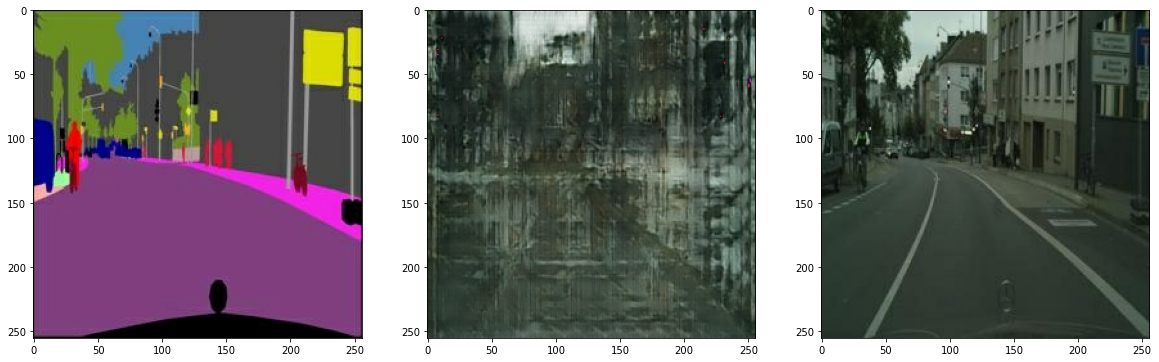

In [53]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(colored))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(sketch))

In [54]:
import os
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
os.listdir(data_path)

['3.jpg', '2.jpg', '4.jpg', '5.jpg', '1.jpg']

In [55]:
from glob import glob
val_paths = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/*'
val_paths = glob(val_paths)
val_paths

['/home/aiffel-dj56/aiffel/conditional_generation/cityscapes/val/3.jpg',
 '/home/aiffel-dj56/aiffel/conditional_generation/cityscapes/val/2.jpg',
 '/home/aiffel-dj56/aiffel/conditional_generation/cityscapes/val/4.jpg',
 '/home/aiffel-dj56/aiffel/conditional_generation/cityscapes/val/5.jpg',
 '/home/aiffel-dj56/aiffel/conditional_generation/cityscapes/val/1.jpg']

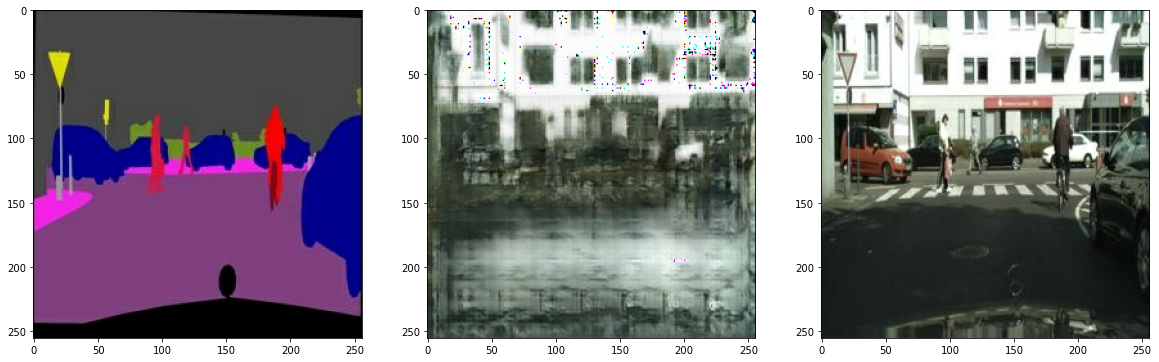

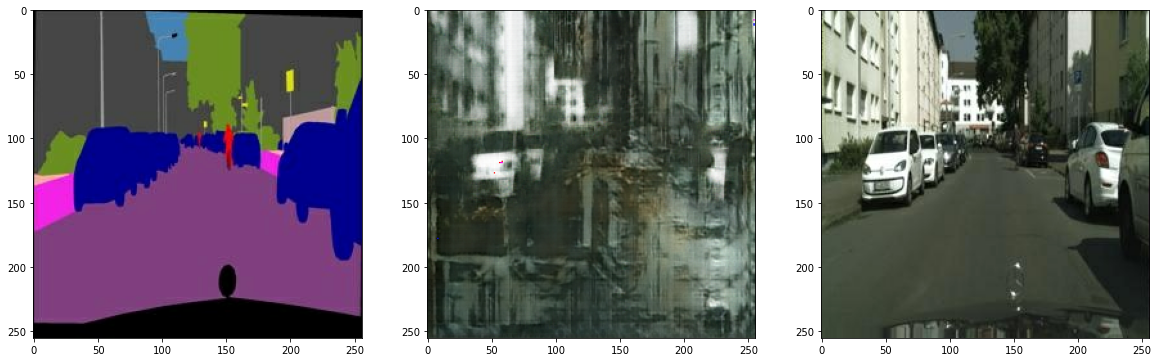

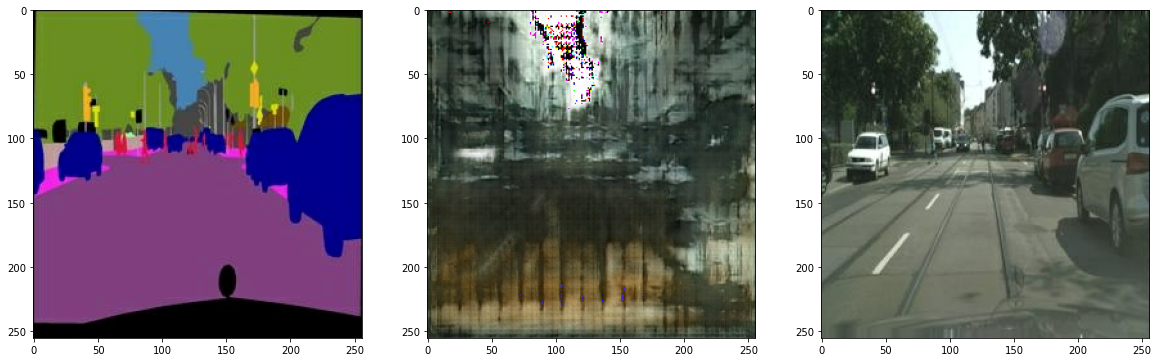

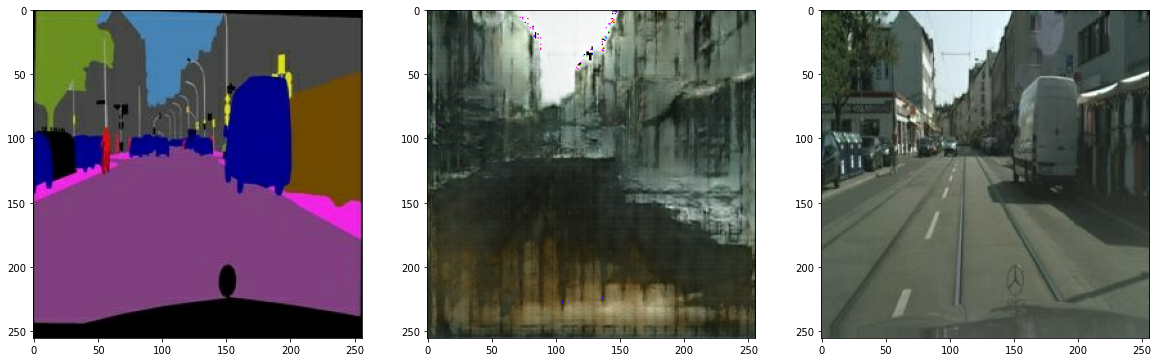

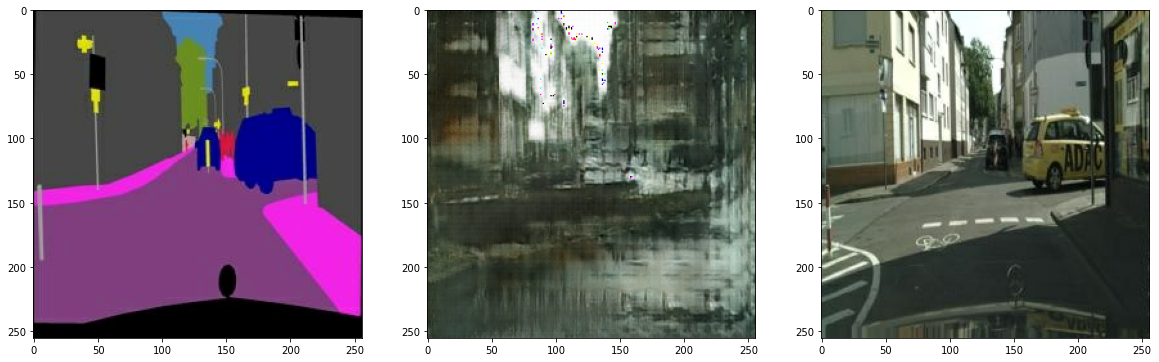

In [56]:
from PIL import Image
for path in val_paths :
    sketch, colored = load_img(path)
    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(colored))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(sketch))
    plt.show()

1. Augmentation적용
    1. 두 이미지가 채널 축으로 연결
    2. 1의 결과에 50% 확률로 Reflection padding, constant padding이 30픽셀의 pad width만큼 적용
    3. 2의 결과에서 (256, 256, 6) 크기를 가진 이미지를 임의로 잘라낸다
    4. 3의 결과물을 50%의 확률로 가로 반전
    - 세로반전과 회전은 수행하지 않는다.
        - 일반적으로 도로사진은 그런 사진이 없기 때문에
    - 의문점
        - 이미지를 concat시키지 않고 짤릴 경우 기존에 이미지는 하얀색 배경이라서 하얀색이 있는게 문제가 되지 않지만, 도로 이미지의 경우 기존에 segmap에는 색칠이 다 되어 있기 때문에 흰색이 오히려 학습에 도움이 되지 않을 것 같다.
          

<br>  
        
2. U-Net generator, discriminator 사용
    - Generator부분에서 Encoder와 Decoder 사이를 skip connection으로 연결시켜주고 있다.
    - Concatenate layer를 활용, 기존 Encoder의 Output을 Decoder에 연결시키기 위해 역순으로 사용한다.
    - Encoder의 마지막 output은 따로 skip connection을 사용하지 않아도 Decoder에 연결되기 때문에 제외

<br>  
  
3. 

**50 epoch 학습** 

   - 10 epoch에 비해서는 훨씬 좋아졌지만 여전히 좋지 않음  
   ![image](img/E20-50.png)   
    
    
**100 epoch 학습**  
   
   - 50에 비해 좀더 명확한 윤곽을 확인해 볼 수 있음  
   - 그래도 이미지 상의 트럭은 거의 나오지 않음     
   ![image](img/E20-100.png) 

    
# 루브릭
아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항/상세기준

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.  
데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.


2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.  
U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.


3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.  
10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.


# 회고
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**


***
***

# ◈ 결과 및 고찰

엄청난 수행 시간으로 다른 시도를 해보는 것에 많은 제약이 있었다.   
cGAN 및 Pix2Pix의 구조와 학습 방법을 이해하는데 어려움이 많았다. 
신경망 모델에 대한 이해도가 깊지 않기 때문이지 않을까 생각해 보았다. 
이 기술을 가지고 어떤 응용이 가능할지 잘 알 수가 없었다. 